Eldar Mammadli - Graduate Project - CSCI E-83 Fundamental of Data Science


# Forecasting San Francisco Crime Incidents 


## Executive summary


In modern world because of job offer or for having more job opportunities many people move to big cities. Along with better job opportunities there are other factors that are important for standards of living like quality of enviroment, healthcare and other. For instance San Francisco's economy is growing, but crime rate is higher than the US average and its wealth seems to be heavily undistributed. Many would like to understand how safe is San Francisco, and what to expect in the future in terms of crime. Also other questions arise if someone is already in a city like San Francisco. For instance is it safe to park car or what incidents can happen in some district at specific time?.   In an example of San Francisco city I will address questions listed above. 

The purpose of this project is to build time series machine learning models and visualisations addressing following questions in the San Francisco city: 
- Does number of criminal incidents increasing? What is the forecast for next 1 years? Is there seasonality component available in the time series?

For that purpose the crime incidents report dataset will be used. Since we are concentrated on prediction in San Francisco and certain grouped categories of incidents the dataset will be cleaned. After cleaning the data other correlated exogenous predictors will be identified. From the obeservation we were able to identify holidays/big events predictors. Also since data includes COVID pandemic period, restrictions exogenous predictors are used to improve the fit.

Using ACF/PACF it was identified that there is correlation between different lags. Also it was identified seasonality of 7 days. By adding different lags to the Linear model it was identified correlations at lags 1, 2, 3, 4, 7, 13, 40, 61 and 365. For all other models this correlation (mostly as an exogenous predictor) is used. 

For 4 types of models (Linear regression, SARIMAX, Poisson regression and Neural Networs) test RMSE was calculated to compare the models. The models with same predictors had similar results.

In terms of test RMSE SARIMAX performs best and have chosen as final model SARIMAX(5,0,1,0,0,0,0, exog). But the most important predictors are egogenous predictors that we could identify previously. The majority of hikes and drops of incidents are because of holidays and big event in San Francisco. Also usually starting from monday until friday number of incidents increases and weekends drops. At the Christmas number of incidents drop significantly and rise at new year's eve. When looking at the plot we can see that at the beginning of the year until end of June number of incidents are relatively less than before and after.

In the project we predict incidents of all categories in entire San Francisco. But similarly from the filtered dataset and applying similar technics incidents for specific category and location or district can be identified and predicted.


## Overview

Used data: San Francisco Police Department Incident Reports: [2018 to Present](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783).

- Importing libraries
- Custom Function
- Data Gathering
- Data Description, overview of the dataset (columns, datatypes, missing data)
- Visualizations
    - historical data (monthly, and yearly) 
    - incidents for each crime category, district, category and time
    - crime incidents visualization on the map   
- Linear Regression
- SARIMAX
- Poisson Regression
- Neural Networks (Extra)
- Comparition of test RMSE of the models
- Prediction
- Conclusion

## Importing libraries

In [1958]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import warnings

from calendar import monthrange
from shapely.geometry import Point
from scipy.stats import boxcox

from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import statsmodels.discrete.discrete_model as dm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from patsy import dmatrices

from pmdarima.arima import auto_arima

import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import regularizers
from tqdm.keras import TqdmCallback

## Custom Function

In [1959]:
#Residuals Plot helper function for plotting cook's distance lines
def graph(formula, x_range, label=None, ax=ax):

    x = x_range
    y = formula(x)
    ax.plot(x, y, label=label, lw=1, ls='--', color='red')


#Residuals Plot
##Residuals vs Fitted
##Scale-Location
##Normal Q-Q
##Residuals vs Leverage
def diagnostic_plots(X, y, model_fit=None):

    if not model_fit:
        model_fit = sm.OLS(y, sm.add_constant(X)).fit()

    dataframe = pd.concat([X, y], axis=1)

    model_fitted_y = model_fit.fittedvalues
    model_residuals = model_fit.resid
    model_norm_residuals = model_fit.get_influence().resid_studentized_internal
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    model_abs_resid = np.abs(model_residuals)
    model_leverage = model_fit.get_influence().hat_matrix_diag
    model_cooks = model_fit.get_influence().cooks_distance[0]
    
    fig, axs = plt.subplots(2, 2, figsize=(19, 10))
    font_size = 8

    ## Residuals vs Fitted 0,0
    sns.residplot(model_fitted_y, dataframe.columns[-1], data=dataframe,
                                                        lowess=True,
                                                        scatter_kws={'alpha': 0.5},
                                                        line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},ax=axs[0, 0])

    axs[0, 0].set_title('Residuals vs Fitted')
    axs[0, 0].set_xlabel('Fitted values')
    axs[0, 0].set_ylabel('Residuals');
    abs_resid = model_abs_resid.sort_values(ascending=False)
    abs_resid_top_3 = abs_resid[:3]
    for i in abs_resid_top_3.index:
        axs[0, 0].annotate(i, xy=(model_fitted_y[i], model_residuals[i]), fontsize=font_size, rotation=60);

    ## Normal Q-Q 0,1
    QQ = ProbPlot(model_norm_residuals)
    QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1, ax=axs[0, 1])
    axs[0, 1].set_title('Normal Q-Q')
    axs[0, 1].set_xlabel('Theoretical Quantiles')
    axs[0, 1].set_ylabel('Standardized Residuals');
    abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
    abs_norm_resid_top_3 = abs_norm_resid[:3]
    for r, i in enumerate(abs_norm_resid_top_3):
        axs[0, 1].annotate(i, xy=(np.flip(QQ.theoretical_quantiles, 0)[r], model_norm_residuals[i]), 
                           fontsize=font_size, rotation=60);

    
    ## Scale-Location 1,0
    axs[1, 0].scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
    sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
                            scatter=False,
                            ci=False,
                            lowess=True,
                            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
               ax=axs[1, 0]);
    axs[1, 0].set_title('Scale-Location')
    axs[1, 0].set_xlabel('Fitted values')
    axs[1, 0].set_ylabel('$\sqrt{|Standardized Residuals|}$');
    abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
    abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
    for i in abs_norm_resid_top_3:
        axs[1, 0].annotate(i, xy=(model_fitted_y[i],model_norm_residuals_abs_sqrt[i]), fontsize=font_size, rotation=60);


    ## Residuals vs Leverage 1,1
    axs[1, 1].scatter(model_leverage, model_norm_residuals, alpha=0.5);
    sns.regplot(model_leverage, model_norm_residuals,
                            scatter=False,
                            ci=False,
                            lowess=True,
                            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=axs[1, 1]);
    axs[1, 1].set_xlim(0, max(model_leverage)+0.01)
    axs[1, 1].set_ylim(-3, 5)
    axs[1, 1].set_title('Residuals vs Leverage')
    axs[1, 1].set_xlabel('Leverage')
    axs[1, 1].set_ylabel('Standardized Residuals');
    leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
    for i in leverage_top_3:
        axs[1, 1].annotate(i, xy=(model_leverage[i], model_norm_residuals[i]), fontsize=font_size, rotation=60);

    p = len(model_fit.params) # number of model parameters
    graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),
                np.linspace(0.001, max(model_leverage), 50, axs[1, 1]),
                'Cook\'s distance') # 0.5 line
    graph(lambda x: np.sqrt((1 * p * (1 - x)) / x),
                np.linspace(0.001, max(model_leverage), 50, axs[1, 1])) # 1 line


#Splitting dataset to train and test with 80:20 ratio
#Adding lags and dropping rows with na in lags
#Lambda value if transformation is needed
def trainTest(data, lags_=[], lambda_=1):
    
    i_len = len(data.index)
    train_size = int(i_len * 0.80)
    
    data['Incidents'] = data['Incidents']**lambda_

    if len(lags_) > 0:
        for i in lags_:
            result_['Incidents_'+str(i)] = result_['Incidents'].shift(i)
            
    return data[0:train_size].dropna(inplace=False), data[train_size:i_len]

#Returns smoothed data with default level of 0.02
def smoothData(data, level_=0.02, freq_="D"):
    return SimpleExpSmoothing(
        pd.Series(data, index=pd.date_range(min(data.index),periods=data.shape[0], freq=freq_)), 
        initialization_method="heuristic").fit(
            smoothing_level=level_, optimized=False
        ).fittedvalues


#Plots multiple time series in one plot
def plotTS(series_list, title_="Crime incidents", ylabel_ = "Incidents", xlim_=[datetime.date(2017, 12, 20), datetime.date(2022, 10, 10)]):
    
    fig,ax = plt.subplots(figsize=(19, 6))
    
    for ser_ in series_list:
        if ser_[2] == "l":
            ax.plot(ser_[0] , label=ser_[1], linewidth=1)
        else:
            ax.scatter(ser_[0].index, ser_[0] , label=ser_[1], color="red")#.plot(, marker='o')

    ax.set_ylabel(ylabel_, fontsize = 14)
    ax.set_xlim(xlim_)
    ax.legend()

    plt.title(title_)
    plt.show()


#Plots ACF and PACF for series
def acfPacf(data, title_="ACF and PACF", lag_=60):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(15,4))
    fig.suptitle(title_,y=1.08,size=16)
    plt.subplots_adjust(wspace = 0.15)
    plot_acf(data, ax=ax[0], lags=lag_)
    plot_pacf(data, ax=ax[1], lags=lag_, method='ywm')

    for k in range(2):
        ax[k].tick_params(axis='both', labelsize=12)
        [ax[k].spines[line].set_alpha(.3) for line in ["top","bottom","right","left"]]

    ax[0].set_title("ACF")
    ax[1].set_title("PACF")
    

#Calculates and returns RMSE
def RMSE(actual, prediction):
    
    rmse_ = np.sqrt(mean_squared_error(actual, prediction)) 
    print("RMSE: ", rmse_)
    
    return rmse_


## Stepwise prediction because of lag OLS, Poisson, SARIMAX, NN 
## data includes columns with already know values of different Lags. The rest will be set after prediction
def stepPredict(model, data, lags, type_="linear"):
    
    data_ = data.copy()
    predictions = []
    
    for i in range(0, data_.shape[0]):
        
        #Setting previous predictions to different Lags
        for k in lags:
            try:
                data_.iloc[i, data_.columns.get_loc('Incidents_'+str(k))] = predictions[-k]
            except IndexError:
                pass
        
        pred = 0
        if type_ == "poisson":
            expr = "Incidents ~ " + " + ".join(str(x) for x in data_.iloc[[i]].drop(columns=['Incidents']).columns)
            y_test, X_test = dmatrices(expr, data_.iloc[[i]], return_type='dataframe')
            
            pred = model.predict(X_test)[0]

        elif type_ == "sarimax":
            pred = model.get_forecast(steps=i+1, exog=data_[:(i+1)].drop(columns=['Incidents'])).predicted_mean[-1]
        elif type_ == "NN":
            pred = model.predict(data_.iloc[[i]].drop(columns=['Incidents']), verbose=0)[0][0]
        else:
            pred = model.predict(data_.iloc[[i]].drop(columns=['Incidents']))[0]
            
        predictions.append(pred)
    
    predictions = pd.Series(predictions)
    predictions.index = data_.index
       
    return predictions

#Variance Inflation Factor - values greater than 10 means there is multicollinearity, some predictors can be dropped
def printVIF(data):
    
    vif_data = pd.DataFrame()
    vif_data["feature"] = data.columns
  
    vif_data["VIF"] = [variance_inflation_factor(data.values, i)
                          for i in range(len(data.columns))]
    
    print(vif_data)
    

# Generates Test data (exogenous predictors) exog_ for future prediction 
def generateTest(result=pd.DataFrame(),covid_restrictions=pd.DataFrame(),events=pd.DataFrame(), lags=[365], range_=pd.date_range(start="2022-10-1", end="2023-9-29") ):
    
    #Create empty dataframe with Date column of range range_
    exog_ = pd.DataFrame(columns=['Date'])
    for aDay in range_:
        exog_.loc[len(exog_.index)] = aDay
        
    
    #Merge columns of restrictions and events
    exog_ = pd.merge(pd.merge(exog_, covid_restrictions, on='Date', how='left'), events, on='Date', how='left')
    exog_['Holiday'] = exog_['Holiday'].fillna("NotHoliday")
    exog_['Holiday'] = exog_['Holiday'].astype("category")
    exog_['DayOfWeek'] = exog_['Date'].dt.strftime('%A')
    exog_['WeekNumber'] = exog_['Date'].dt.strftime("%U").astype(np.int32)

    exog_.set_index('Date', inplace=True)
    exog_ = pd.get_dummies(exog_)

    #Drop some predictors to eliminate multicollinearity
    exog_ = exog_.fillna(0)
    exog_ = exog_.drop(columns=['NEBusinessClose','BusinessMask'])

    result_ = result.copy()

    #Adding Lag columns to dataset
    for i in lags:
        emp_list = np.zeros((1,365))[0]
        lag_list = list(result.tail(i)['Incidents'])
        for k in range(0, len(lag_list)):
            emp_list[k] = lag_list[k]
    
        exog_['Incidents_'+str(i)] = emp_list
        result_['Incidents_'+str(i)] = result_['Incidents'].shift(i)

    result_ = result_.dropna(inplace=False)

    #Adding missing Dummy columns to exog_
    for col in set(result_.columns) - set(exog_.columns):
        if col != 'Incidents':
            exog_[col] = 0

    exog_ = exog_[list(result_.columns[1:])]
    
    return result_, exog_


## Data Gathering 

First the data of Incidents report will be loaded and first columns will be observed.

In [1960]:
#LOAD DATA 2018 - PRESENT
cin = pd.read_csv('./data/Police_Department_Incident_Reports__2018_to_Present.csv')
#cin_03_18 = pd.read_csv('./data/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv')

print("Dimentions of the dataset: ", cin.shape)

cin.head(5)

Dimentions of the dataset:  (646475, 34)


,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,CAD Number,...,Longitude,Point,Neighborhoods,ESNCAG - Boundary File,Central Market/Tenderloin Boundary Polygon - Updated,Civic Center Harm Reduction Project Boundary,HSOC Zones as of 2018-06-05,Invest In Neighborhoods (IIN) Areas,Current Supervisor Districts,Current Police Districts
0,2021/07/25 12:00:00 AM,2021/07/25,00:00,2021,Sunday,2021/07/25 01:41:00 PM,105718906372,1057189,216105573,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022/06/28 11:58:00 PM,2022/06/28,23:58,2022,Tuesday,2022/06/28 11:58:00 PM,116554371012,1165543,220264913,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022/03/11 10:30:00 AM,2022/03/11,10:30,2022,Friday,2022/03/11 08:03:00 PM,113048071000,1130480,226040232,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021/05/15 05:47:00 PM,2021/05/15,17:47,2021,Saturday,2021/05/15 05:47:00 PM,103051807043,1030518,210183345,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022/06/28 05:22:00 PM,2022/06/28,17:22,2022,Tuesday,2022/06/28 05:22:00 PM,116535107041,1165351,220361741,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Data contains list of incidents from 2018 until present(current). The dataset includes 646475 reports with information in 34 columns. Before transformin data to the Time Series some transformations will be applied to the dataset:
- filtering out data after September 30th 2022
- changing column names 
- capitalization of text columns
- filtering out incidents outside of San Francisco
- dropping na values
- categories of incidents will be more generalised
- additional values as new columns will be added to data set: year, month, day, day of week, month-year(containing year and month values in one string), time-period(grouping column for incidents time period of 3 hours - incidents from 00:00 to 03:00, from 03:00 to 06:00 and so on).

In [1961]:
#PREPARING DATA
cin['Date'] = pd.to_datetime(cin['Incident Date'], format = '%Y/%m/%d')
cin = cin[cin['Date'] < '2022-10-01']

cin = cin.sort_values('Incident Category', ascending=False, na_position='first')

#GROUP BY 'Incident Number', SETTING MOST COMMON CATEGORY
cin_u = cin.groupby(['Incident Number', 'Incident Category']).size().reset_index(name='count').sort_values(by=['Incident Number', 'count'], ascending=False).reset_index(drop=True).drop_duplicates(subset=['Incident Number'], keep='first')
cin_u = cin_u[['Incident Number', 'Incident Category']]
cin_u.columns = ['num', 'cat']
cin = pd.merge(cin, cin_u, left_on='Incident Number', right_on='num', how="left")

In [1962]:
cin = cin.drop_duplicates(subset=['Incident Number'], keep='last')

cin = cin[['Date', 'Incident Time', 'Incident Day of Week',
       'cat', 'Incident Description', 'Latitude', 'Longitude', 'Police District']]
cin.columns = ['Date', 'Time', 'DayOfWeek', 'Category', 'Descript', 'Latitude', 'Longitude', 'PdDistrict']

for col in ['Category', 'Descript', 'PdDistrict']:
    cin[col] = cin[col].str.capitalize()
    
#cin = cin[(cin['PdDistrict'] != 'Out of sf')]
#cin = cin.dropna(subset=['PdDistrict', 'Longitude', 'Latitude'])
cin = cin.dropna(subset=['PdDistrict'])



cin = cin[(cin['PdDistrict'] != 'Out of sf') & 
          (~cin['Category'].isin(['Case closure', 'Non-criminal', 'Civil sidewalks',
                                  'Recovered vehicle']) ) ]



cin['Category'] = cin['Category'].fillna("Other")

cin['Category'] = cin['Category'].replace(['Motor vehicle theft?',
                                           'Human trafficking (a), commercial sex acts',
                                           'Weapons offence'],
                                          ['Motor vehicle theft',
                                           'Human trafficking, commercial sex acts',
                                           'Weapons offense'])




cin['TopCategory'] = cin['Category'].replace(['Arson', 'Assault', 'Burglary', 
                                           'Courtesy report', 'Disorderly conduct', 'Drug offense', 
                                           'Drug violation', 'Embezzlement', 'Fire report', 
                                           'Forgery and counterfeiting', 'Fraud', 'Gambling', 
                                           'Homicide', 'Human trafficking, commercial sex acts', 'Larceny theft', 
                                           'Liquor laws', 'Lost property', 'Malicious mischief', 
                                           'Miscellaneous investigation', 'Missing person', 'Motor vehicle theft', 
                                           'Offences against the family and children', 'Other', 'Other miscellaneous', 
                                           'Other offenses', 'Prostitution', 'Rape', 
                                           'Robbery', 'Sex offense', 'Stolen property', 
                                           'Suicide', 'Suspicious', 'Suspicious occ', 
                                           'Traffic collision', 'Traffic violation arrest', 'Vandalism', 
                                           'Vehicle impounded', 'Vehicle misplaced', 'Warrant', 
                                           'Weapons carrying etc', 'Weapons offense'],
                                          ['Other reports', 'Assault', 'Larceny theft', 
                                           'Other reports', 'Disorderly conduct', 'Drug violation', 
                                           'Drug violation', 'Larceny theft', 'Other reports', 
                                           'Fraud', 'Fraud', 'Gambling/Liquor laws', 
                                           'Homicide', 'Sex offense', 'Larceny theft', 
                                           'Gambling/Liquor laws', 'Other reports', 'Gambling/Liquor laws', 
                                           'Warrant/Investigation', 'Missing person', 'Larceny theft', 
                                           'Other offenses', 'Other offenses', 'Other offenses', 
                                           'Other offenses', 'Sex offense', 'Sex offense', 
                                           'Larceny theft', 'Sex offense', 'Larceny theft', 
                                           'Suicide', 'Suspicious', 'Suspicious', 
                                           'Traffic incidents', 'Traffic incidents', 'Disorderly conduct', 
                                           'Vehicle impounded', 'Traffic incidents', 'Warrant/Investigation', 
                                           'Weapons offense', 'Weapons offense'])

cin['Year'] = pd.DatetimeIndex(cin['Date']).year
cin['Month'] = pd.DatetimeIndex(cin['Date']).month
cin['Day'] = pd.DatetimeIndex(cin['Date']).day
cin['Year_Month'] = pd.to_datetime(cin['Date']).dt.to_period('M').astype(str)
cin['Time_Period'] = cin['Time'].apply(lambda x: 3*(int(int(x.split(":")[0])/3)) )

cin = cin.sort_values(by=['Date', 'Time']).reset_index(drop=True)

## Data Description

After eliminating unrelated data the total number of incidents decreased to 424094. The is our final data from which time series will be created. 

In [1963]:
print("Dataset info after preparation")
cin.info(verbose = True, show_counts = True) 

Dataset info after preparation
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424095 entries, 0 to 424094
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Date         424095 non-null  datetime64[ns]
 1   Time         424095 non-null  object        
 2   DayOfWeek    424095 non-null  object        
 3   Category     424095 non-null  object        
 4   Descript     424095 non-null  object        
 5   Latitude     404597 non-null  float64       
 6   Longitude    404597 non-null  float64       
 7   PdDistrict   424095 non-null  object        
 8   TopCategory  424095 non-null  object        
 9   Year         424095 non-null  int64         
 10  Month        424095 non-null  int64         
 11  Day          424095 non-null  int64         
 12  Year_Month   424095 non-null  object        
 13  Time_Period  424095 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(7)

In [1964]:
cin['Category'] = cin['Category'].fillna("No Category")
print("NA values for each column\n")
for col in cin:
    print(col,":",cin[col].isna().sum())

NA values for each column

Date : 0
Time : 0
DayOfWeek : 0
Category : 0
Descript : 0
Latitude : 19498
Longitude : 19498
PdDistrict : 0
TopCategory : 0
Year : 0
Month : 0
Day : 0
Year_Month : 0
Time_Period : 0


In [1965]:
cin.tail(5)

,Date,Time,DayOfWeek,Category,Descript,Latitude,Longitude,PdDistrict,TopCategory,Year,Month,Day,Year_Month,Time_Period
424090,2022-09-30,23:00,Friday,Larceny theft,"Theft, from locked vehicle, >$950",37.753201,-122.500045,Taraval,Larceny theft,2022,9,30,2022-09,21
424091,2022-09-30,23:20,Friday,Other miscellaneous,"Driving, no license issued",37.775514,-122.406296,Southern,Other offenses,2022,9,30,2022-09,21
424092,2022-09-30,23:30,Friday,Larceny theft,"Theft, vehicle strip, >$950",37.756929,-122.500305,Taraval,Larceny theft,2022,9,30,2022-09,21
424093,2022-09-30,23:41,Friday,Missing person,Missing adult,37.762332,-122.504988,Taraval,Missing person,2022,9,30,2022-09,21
424094,2022-09-30,23:55,Friday,Motor vehicle theft,"Vehicle, stolen, auto",37.744587,-122.483322,Taraval,Larceny theft,2022,9,30,2022-09,21


## Aggregation

In [1966]:
print("Yearly Incidents(2022 is until october)")

cin_year = cin.groupby(['Year']).size().reset_index(name='Counts')

cin_year.T

Yearly Incidents(2022 is until october)


,0,1,2,3,4
Year,2018,2019,2020,2021,2022
Counts,100359,97445,76326,84734,65231


In [1967]:
print("Monthly Incidents (Pivot Table) per day")

cin_month = cin.groupby(['Year', 'Month']).size().reset_index(name='Counts')
cin_month_pivot = pd.pivot_table(cin_month, index='Month',columns='Year', values='Counts', aggfunc=sum)

#cin_month_pivot_per_day = cin_month_pivot.apply(lambda x: pd.DataFrame(x).apply(lambda y: y.values[0]/monthrange(x.name, y.name)[1], axis=1))

cin_month_pivot.apply(lambda x: pd.DataFrame(x).apply(lambda y: "{:.2f}".format(y.values[0]/monthrange(x.name, y.name)[1]), axis=1)).T


Monthly Incidents (Pivot Table) per day


Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2018,284.65,274.00,262.81,273.13,273.23,271.10,290.16,291.39,276.33,279.16,260.20,262.61
2019,250.26,253.54,244.77,253.63,254.84,265.53,277.90,292.55,283.83,291.71,268.10,265.81
2020,265.84,259.41,199.77,175.77,192.74,197.20,203.06,200.61,194.70,199.58,207.57,207.61
2021,211.65,207.75,196.84,202.27,226.97,243.20,238.81,229.32,255.37,265.10,264.70,242.65
2022,225.97,230.93,240.94,234.43,223.06,250.50,251.42,246.29,246.63,nan,nan,nan


In [1968]:
print("Incidents in different districts")

cin_district = cin.groupby(['PdDistrict']).size().reset_index(name='Incidents').sort_values(by=['Incidents'], ascending=False).reset_index(drop=True)

cin_district.T

Incidents in different districts


,0,1,2,3,4,5,6,7,8,9
PdDistrict,Central,Northern,Mission,Southern,Bayview,Tenderloin,Ingleside,Taraval,Richmond,Park
Incidents,67840,62685,54445,52455,36542,36529,32417,31331,29384,20467


In [1969]:
print("Incidents different Top categories")

cin_category = cin.groupby(['TopCategory']).size().reset_index(name='Incidents').sort_values(by=['Incidents'], ascending=False).reset_index(drop=True)

cin_category.T

Incidents different Top categories


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
TopCategory,Larceny theft,Gambling/Liquor laws,Other offenses,Assault,Other reports,Fraud,Warrant/Investigation,Suspicious,Missing person,Drug violation,Disorderly conduct,Weapons offense,Traffic incidents,Sex offense,Suicide,Vehicle impounded,Homicide
Incidents,237345,34490,34402,32071,18420,16454,12114,9282,9132,8055,7557,2247,1234,1049,122,79,42


In [1970]:
cin.sort_values(by=['TopCategory'])['TopCategory'].unique()

array(['Assault', 'Disorderly conduct', 'Drug violation', 'Fraud',
       'Gambling/Liquor laws', 'Homicide', 'Larceny theft',
       'Missing person', 'Other offenses', 'Other reports', 'Sex offense',
       'Suicide', 'Suspicious', 'Traffic incidents', 'Vehicle impounded',
       'Warrant/Investigation', 'Weapons offense'], dtype=object)

In [1971]:
print("Incidents at different Period of Time(00:00-03:00, 03:00-06:00, and so on) and Categories")

cin_time_period = cin.groupby(['Time_Period', 'TopCategory']).size().reset_index(name='Count').sort_values(by=['Time_Period'])
cin_time_period_pivot = pd.pivot_table(cin_time_period, index='Time_Period',columns='TopCategory', values='Count', aggfunc=sum)

cin_time_period_pivot

Incidents at different Period of Time(00:00-03:00, 03:00-06:00, and so on) and Categories


TopCategory,Assault,Disorderly conduct,Drug violation,Fraud,Gambling/Liquor laws,Homicide,Larceny theft,Missing person,Other offenses,Other reports,Sex offense,Suicide,Suspicious,Traffic incidents,Vehicle impounded,Warrant/Investigation,Weapons offense
Time_Period,,,,,,,,,,,,,,,,,
0,3908,675,443,3701,4170,3,22360,907,3513,2164,238,6,1162,154,4,952,361
3,1475,291,177,254,2378,1,12046,286,1674,677,69,13,429,69,7,410,166
6,2486,766,786,1356,2759,8,15026,914,3442,1524,85,12,931,131,6,1228,118
9,4141,1227,1154,2571,3588,8,29780,1445,4764,2733,76,21,1427,136,22,2057,204
12,5113,1470,2204,3918,4159,11,37864,1842,5773,3357,147,24,1733,199,16,2466,297
15,5466,1288,1819,2413,5222,5,41152,1460,5737,3108,138,20,1502,202,14,2287,309
18,5088,1040,874,1385,6605,4,47844,1267,4821,2618,104,15,1178,161,5,1571,337
21,4394,800,598,856,5609,2,31273,1011,4678,2239,192,11,920,182,5,1143,455


## Visualizations/Insights

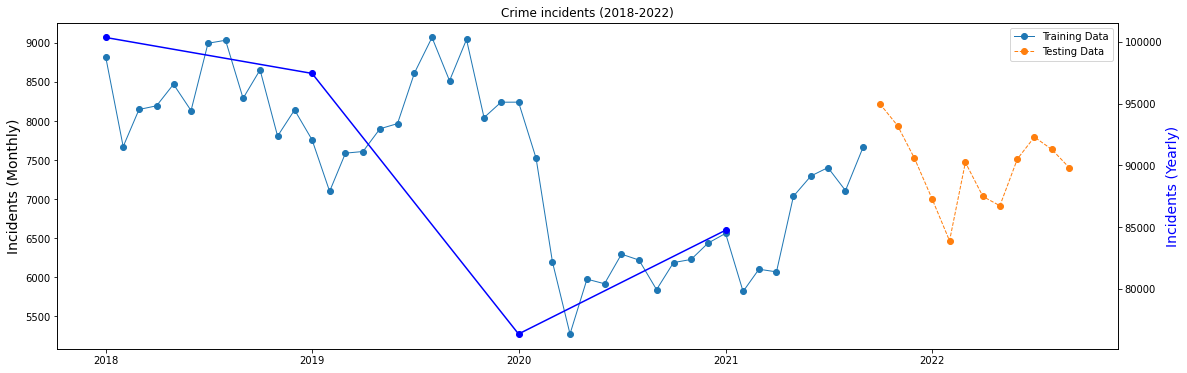

In [1972]:
cin_year_month=cin.groupby(['Year_Month']).size().reset_index(name='Incidents')

cin_year_month['Year_Month'] = pd.to_datetime(cin_year_month['Year_Month'], format='%Y-%m')
cin_year['date'] = pd.to_datetime(cin_year['Year'], format='%Y')

cin_year_month.set_index('Year_Month', inplace=True)

fig,ax = plt.subplots(figsize=(19, 6))

ax.plot(train ,'o-', label='Training Data', linewidth=1)
ax.plot(test, 'o--', label='Testing Data', linewidth=1)
ax.set_ylabel("Incidents (Monthly)", fontsize = 14)
ax.legend()

ax2=ax.twinx()
ax2.plot(cin_year['date'][0:4], cin_year['Counts'][0:4], color="blue",marker="o", label="Yearly")
ax2.set_ylabel("Incidents (Yearly)",color="blue",fontsize=14)

plt.title("Crime incidents (2018-2022)")
plt.show()

From the monthly time series we can see significant drop in incidents around may of 2020. The reason for that was probably restriction policies during covid pandemic. We need to include this information (restriction plocies during covid pandemic) for better model fitting.

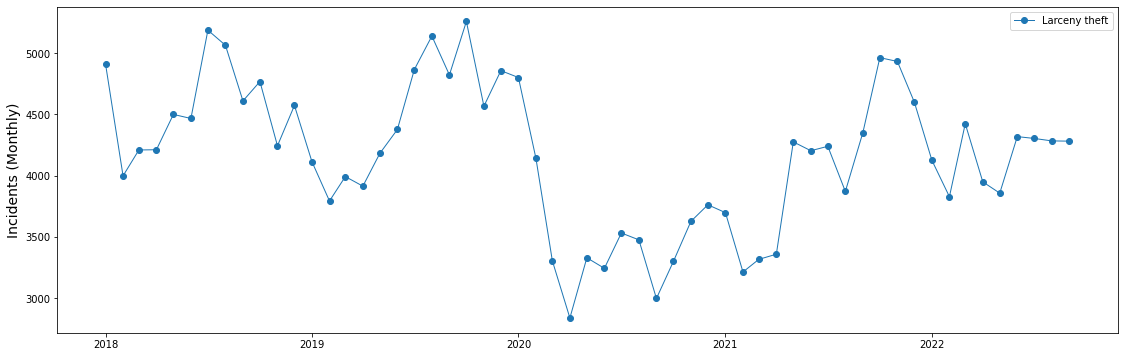

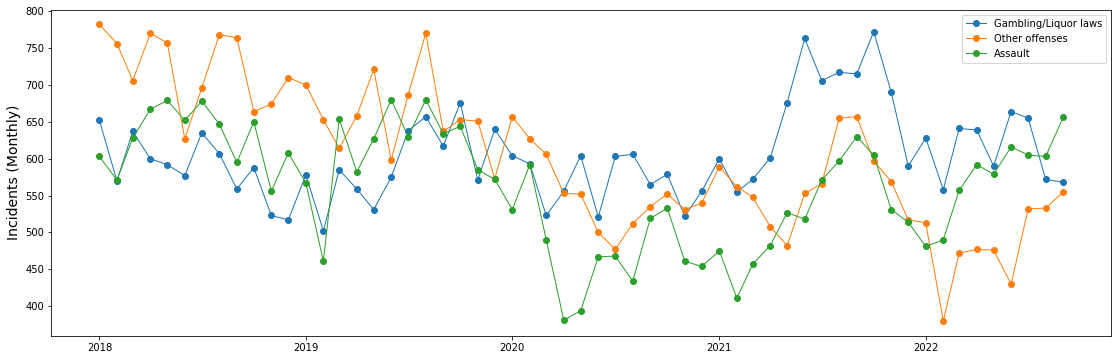

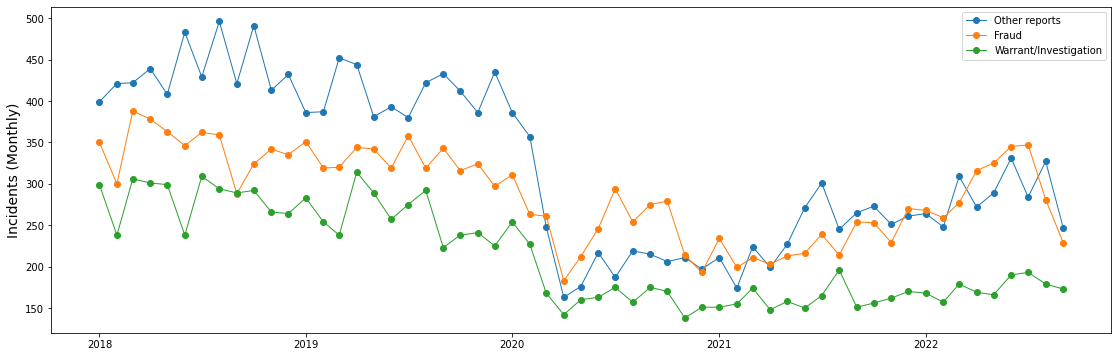

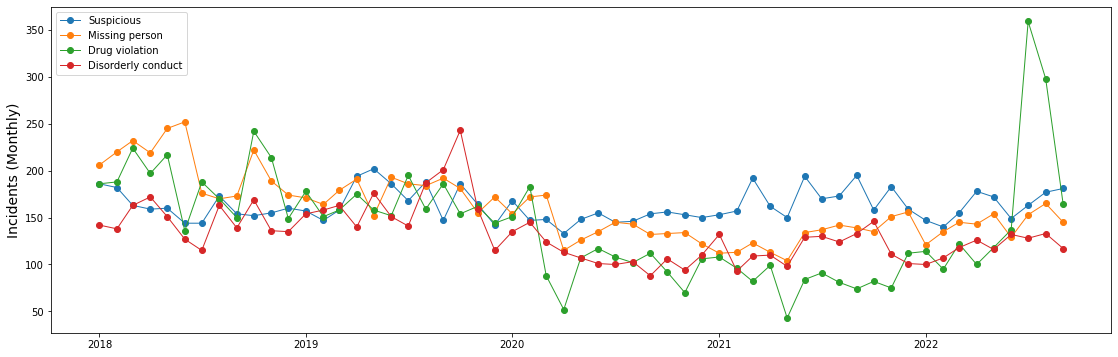

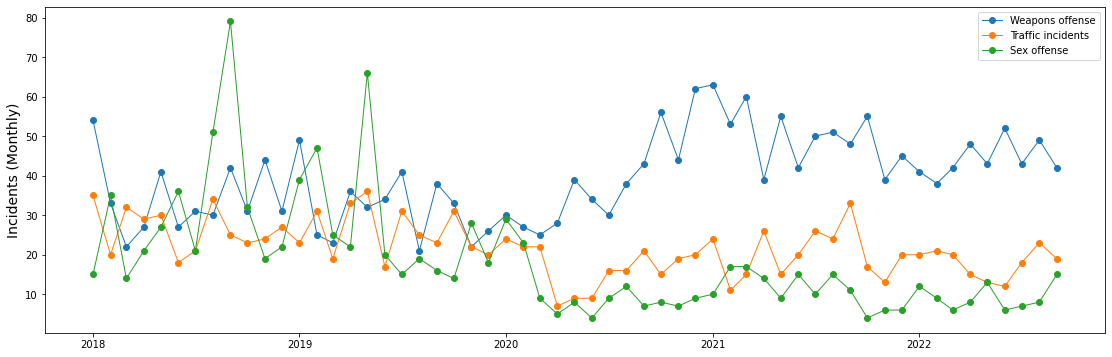

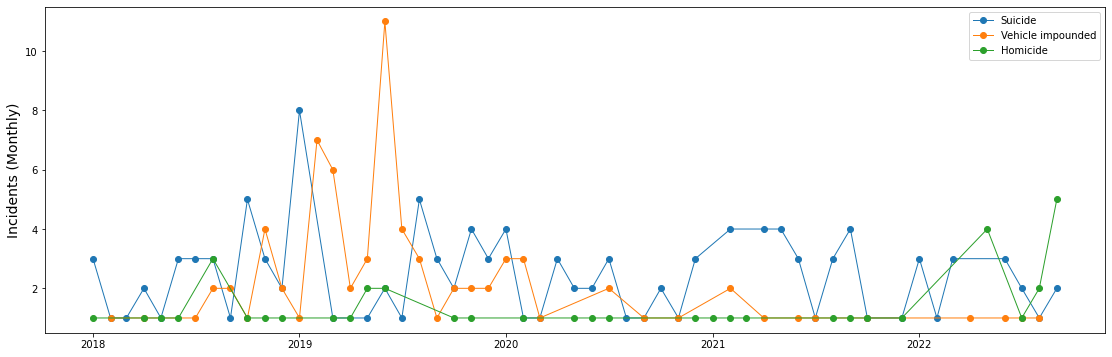

In [1973]:
cin_cat_ts = [x for _, x in cin.groupby(['TopCategory'])]
cin_cat_ts = sorted(cin_cat_ts, key=(lambda x: len(x)), reverse=True)

for i in range(0,len(cin_cat_ts)):
    
    if i in [0,1,4,7,11,14]:
        fig,ax = plt.subplots(figsize=(19, 6))

    cat = cin_cat_ts[i]

    cat_ = cat.groupby(['Year_Month']).size().reset_index(name='Incidents')
    cat_['Year_Month'] = pd.to_datetime(cat_['Year_Month'], format='%Y-%m')
    cat_.set_index('Year_Month', inplace=True)

    ax.plot(cat_ ,'o-', label=cat.TopCategory.unique()[0], linewidth=1 )
    ax.set_ylabel("Incidents (Monthly)", fontsize = 14)
    ax.legend()
    
    

From the previous plots we can see that almost for all categories number of incidents dropped during pandemic. Only number of weapon offense increased and few(suspicious appearance, missing person) did not change.

Text(0.5, 1.0, '(Log-normalized) Incidents for each Top Category on Period of Time')

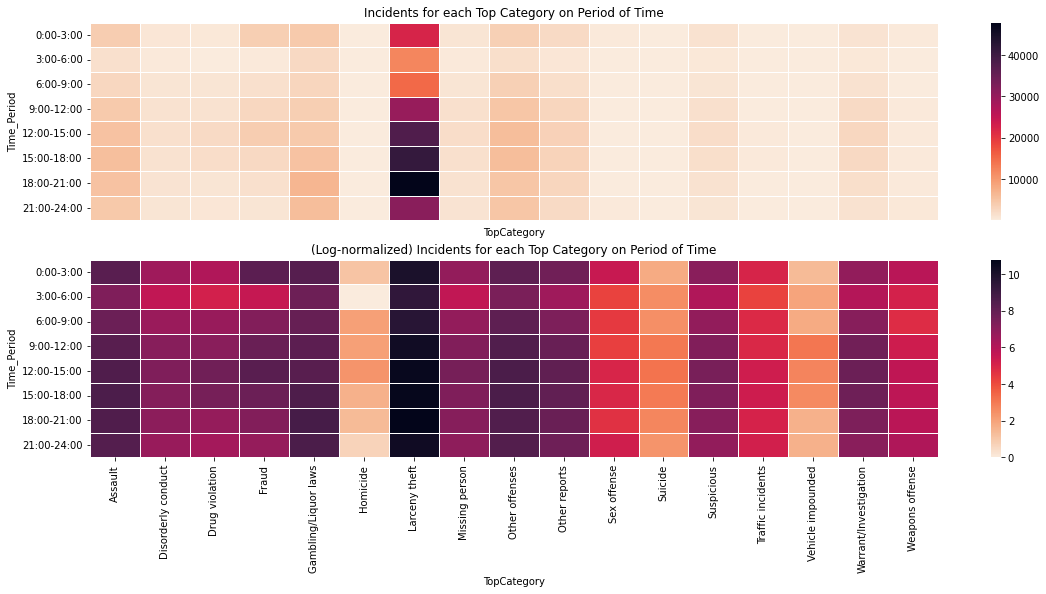

In [1974]:
cmap = sns.cm.rocket_r
f, (ax1,ax2) = plt.subplots(2,1, figsize=(19, 8))
ytick = ['0:00-3:00','3:00-6:00','6:00-9:00','9:00-12:00','12:00-15:00','15:00-18:00','18:00-21:00','21:00-24:00']
sns.heatmap(cin_time_period_pivot, yticklabels=ytick, xticklabels='', linewidths=1, ax=ax1, cmap=cmap).set_title('Incidents for each Top Category on Period of Time')
sns.heatmap(np.log(cin_time_period_pivot), yticklabels=ytick, linewidths=1, ax=ax2, cmap=cmap).set_title('(Log-normalized) Incidents for each Top Category on Period of Time')

The majority of incidents are larceny thefts between 6pm and 9pm.

In [1975]:
cin_coor=cin.groupby(['TopCategory', 'Longitude', 'Latitude']).size().reset_index(name='inc').sort_values(by=['inc'], ascending=False)



rgb_values = ['black','darkred', 'orange', 'teal','deeppink','darkslategray',
             'darkviolet','darkolivegreen','slategray','darkslategray',
             'orange', 
             'steelblue', 'royalblue', 'navy','plum',
             'navy', 'brown','azure']
color_labels = cin_category['TopCategory'].unique()
color_map = dict(zip(color_labels, rgb_values))

y_pos = np.arange(len(color_labels))
performance = np.full((1, len(color_labels)), 1)[0] #[10,8,6,4,2,1]

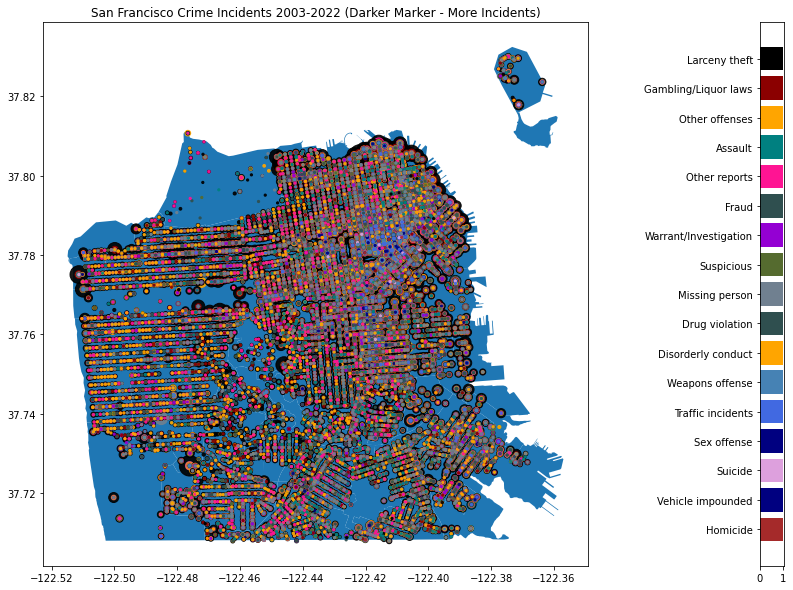

In [1976]:
sf_map = gpd.read_file('./sf_map/SFFind_Neighborhoods.shp')

geo_df = gpd.GeoDataFrame(cin_coor, geometry=gpd.points_from_xy(cin_coor.Longitude, cin_coor.Latitude), crs="EPSG:4326")

fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [30, 1]}, figsize=(15,10))
sf_map['geometry'].plot(ax=ax0, zorder=1)
#geo_df.plot(ax=ax, markersize=30, marker='o', c=1/cin_coor['inc']**.25, alpha=0.9, zorder=2) cin_coor['TopCategory'].map(color_map)
geo_df.plot(ax=ax0, markersize=5*cin_coor['inc']**.6, marker='o', c=cin_coor['TopCategory'].map(color_map), alpha=0.9, zorder=2)
ax0.set_title('San Francisco Crime Incidents 2003-2022 (Darker Marker - More Incidents)');


ax1.barh(y_pos, performance, align='center', alpha=1, color=rgb_values)
ax1.set_yticks(y_pos, color_labels)
ax1.invert_yaxis()

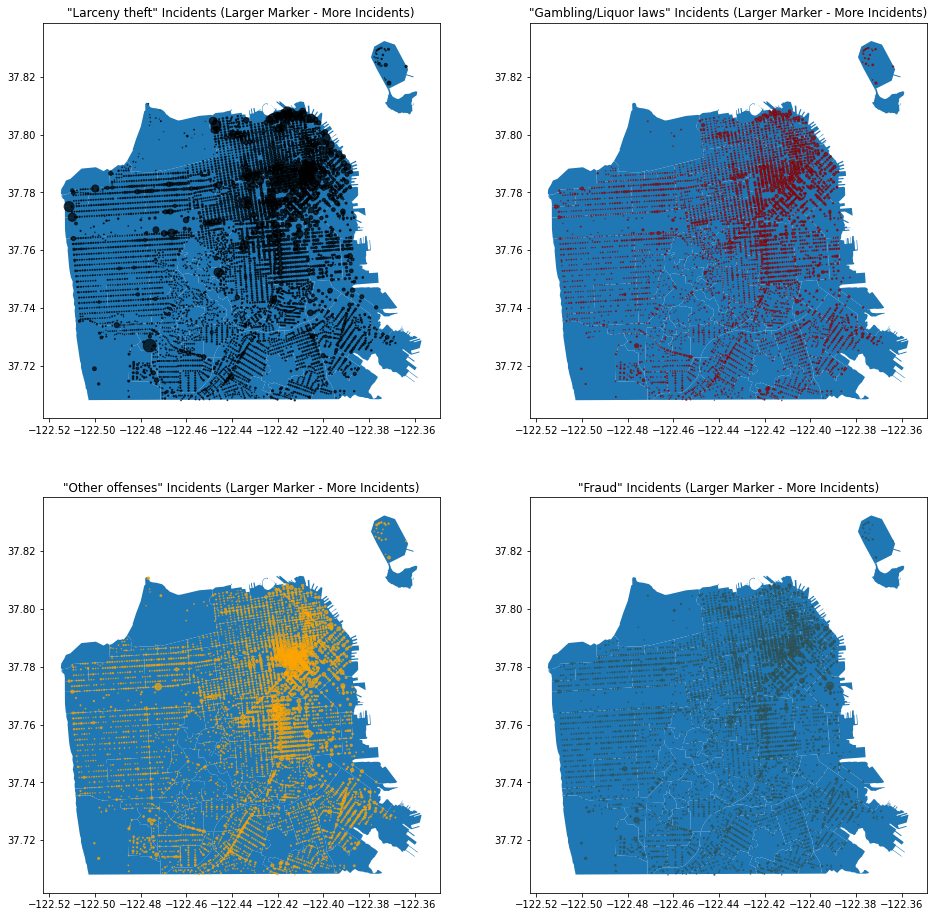

In [1977]:
cin_coor=cin.groupby(['TopCategory', 'Longitude', 'Latitude']).size().reset_index(name='inc').sort_values(by=['inc'], ascending=False)
cin_cat_ts = [x for _, x in cin_coor.groupby(['TopCategory'])]
cin_cat_ts = sorted(cin_cat_ts, key=(lambda x: len(x)), reverse=True)

fig, ax_ = plt.subplots(2,2, figsize=(16,16))
for k in range(0,4):
    
    cat = cin_cat_ts[k]
    
    ax = ax_[int(k/2), k%2]
    geo_df = gpd.GeoDataFrame(cat, geometry=gpd.points_from_xy(cat.Longitude, cat.Latitude), crs="EPSG:4326")
    sf_map['geometry'].plot(ax=ax, zorder=1)
    geo_df.plot(ax=ax, markersize=(k+1)*0.1*cat['inc'], marker='o', c=cat['TopCategory'].map(color_map), alpha=0.7, zorder=2)
    ax.set_title('"'+str(cat['TopCategory'].unique()[0])+'" Incidents (Larger Marker - More Incidents)');
    

From the maps above we can see where the majority of incidents happen. Also from last 4 maps we can see for each category of crime where exactly if compared with other locations more incidents happen (larger marker).

## Predictors for models

Now is time create the time series and and identify additional predictor variables.

Observations: 1734


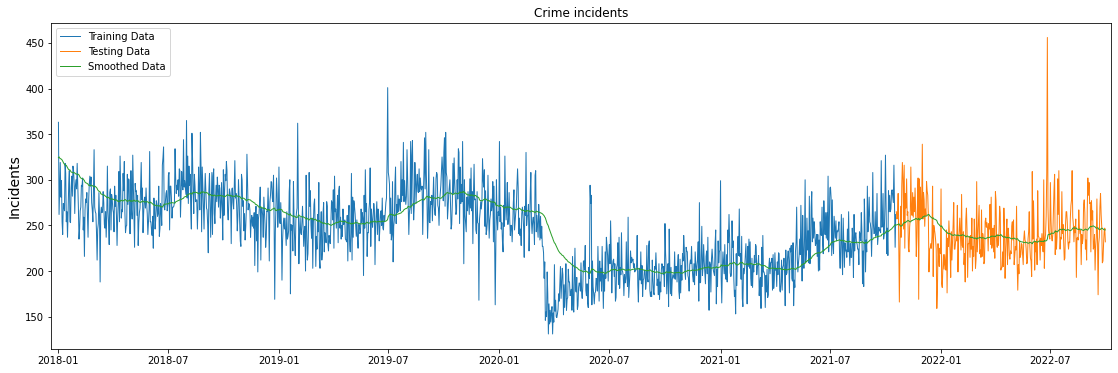

In [1978]:
cin_daily=cin.groupby(['Date']).size().reset_index(name='Incidents')
cin_daily.set_index('Date', inplace=True)

i_len = len(cin_daily.index)
print('Observations: %d' % (i_len))

train_, test_ = trainTest(cin_daily)
smooth_data = smoothData(cin_daily["Incidents"])

plotTS([[train_, "Training Data", "l"],
        [test_, "Testing Data", "l"],
        [smooth_data, "Smoothed Data", "l"]])

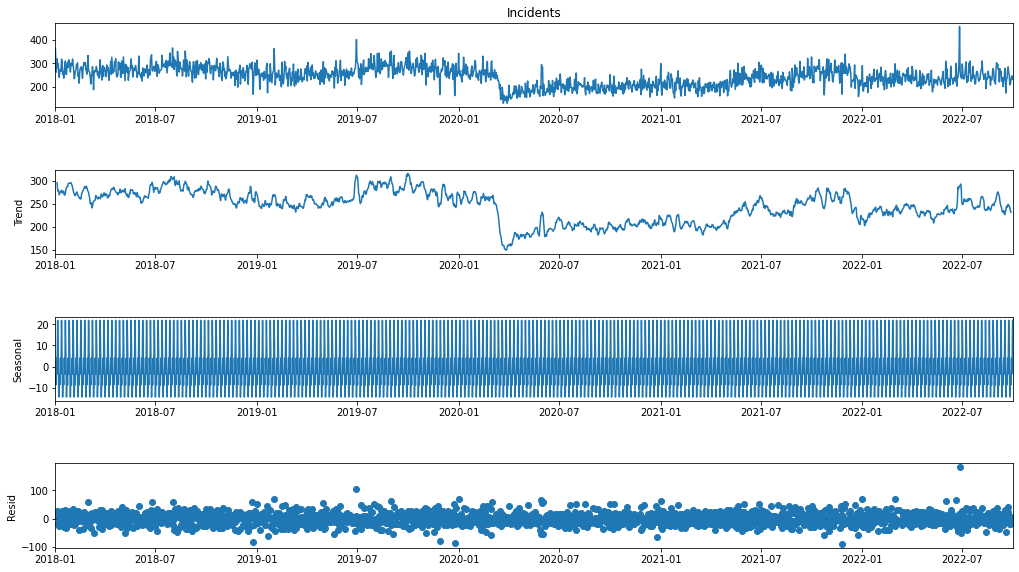

In [1979]:
decomposition = sm.tsa.seasonal_decompose(cin_daily['Incidents'], model='additive')
fig = decomposition.plot()
fig.set_size_inches((16, 9))
plt.show()

Since we can see that there is significant impact of Covid pandemic on crime incidents in SF, predictors of are required to describe drop in incidents. For this purpose restriction policies data in CA will be used as predictor for further models. Also we can se some seasonality of small periods.

In [1980]:
#https://github.com/COVID19StatePolicy/SocialDistancing/tree/master/data
us_restrict = pd.read_csv('./data/USstatesCov19distancingpolicy.csv')

#Only usefull cols #No travel restrictions -4
covid_rest = us_restrict[us_restrict['StatePostal']=='CA'][['StatePolicy', 'Mandate', 'DateEnacted', 
       'DateEased', 'DateEnded']].drop_duplicates().sort_values(by=['StatePolicy', 'DateEnacted', 'DateEased'])[:-4]

covid_rest['Eased'] = covid_rest['DateEased'].shift(1)
covid_rest = covid_rest[covid_rest['DateEnacted']!=covid_rest['Eased']]

covid_rest = covid_rest[(covid_rest['DateEased'].notna()) & (covid_rest['Mandate']==1)]

covid_rest = covid_rest[['StatePolicy', 'DateEnacted','DateEased']]
covid_rest['DateEnacted'] = pd.to_datetime(covid_rest['DateEnacted'], format = '%Y%m%d')
covid_rest['DateEased'] = pd.to_datetime(covid_rest['DateEased'], format = '%Y%m%d')
#print(covid_rest.to_string())

#print(min(cin['Date']), max(cin['Date']))

StatePolicies = list(covid_rest['StatePolicy'].unique())
covid_restrictions = pd.DataFrame(columns=['Date']+StatePolicies)

for aDay in pd.date_range(start=min(cin['Date']), end=max(cin['Date'])):
    StatePolicyTrue = covid_rest[(covid_rest['DateEnacted']<=aDay) & (covid_rest['DateEased']>=aDay)]['StatePolicy'].unique()
    
    newRow = [aDay]
    
    for pol in StatePolicies:
        if pol in StatePolicyTrue:
            newRow.append(1)
        else:
            newRow.append(0)
            
            
    covid_restrictions.loc[len(covid_restrictions.index)] = newRow
    
    
covid_restrictions.head(5)


,Date,BarRestrict,BusinessMask,GathRestrict,NEBusinessClose,OtherBusinessClose,PublicMask,RestaurantRestrict,StayAtHome
0,2018-01-01,0,0,0,0,0,0,0,0
1,2018-01-02,0,0,0,0,0,0,0,0
2,2018-01-03,0,0,0,0,0,0,0,0
3,2018-01-04,0,0,0,0,0,0,0,0
4,2018-01-05,0,0,0,0,0,0,0,0


Also, since we can see some hike and drops in the time series, the holidays and SF big events data will be plotted to identify if there is correlation between number of incidents and holidays/events.

Holidays data:

In [1981]:
#https://www.calendarlabs.com/online-calendar/2022-calendar/us-holidays/
holidays = pd.read_csv('./data/Holidays.csv')
holidays['Date'] = pd.to_datetime(holidays['MonthDay']+holidays['Year'].astype(str), format = '%b-%d%Y')
holidays = holidays[['Date', 'Holiday']].sort_values(by=['Date'])

holidays.head(5)

,Date,Holiday
0,2018-01-01,NewYearsDay
6,2018-01-15,MLKingDay
12,2018-02-14,ValentinesDay
1,2018-02-19,PresidentsDay
7,2018-03-30,GoodFriday


San Francisco big events:

In [1982]:
#https://en.wikipedia.org/wiki/San_Francisco_Pride
sf_pride = pd.read_csv('./data/SFPride.csv')

sf_pride['Date'] = pd.to_datetime(sf_pride['Date'], format = '%d/%m/%Y')
sf_pride.columns = ['Date', 'Holiday']

sf_pride.head(5)

,Date,Holiday
0,2018-06-24,SanFranciscoPride2
1,2019-06-30,SanFranciscoPride2
2,2022-06-26,SanFranciscoPride2
3,2018-06-23,SanFranciscoPride1
4,2019-06-29,SanFranciscoPride1


Concatinated holidays and events:

In [1983]:
events = pd.concat( [holidays, sf_pride], ignore_index=True)

print(events.shape, len(events['Date'].unique()))

(107, 2) 106


Merging Daily incidents, holidays and SF events to one dataframe. Adding predictor day of the week and week number in the year for each day and updating train and test datasets:

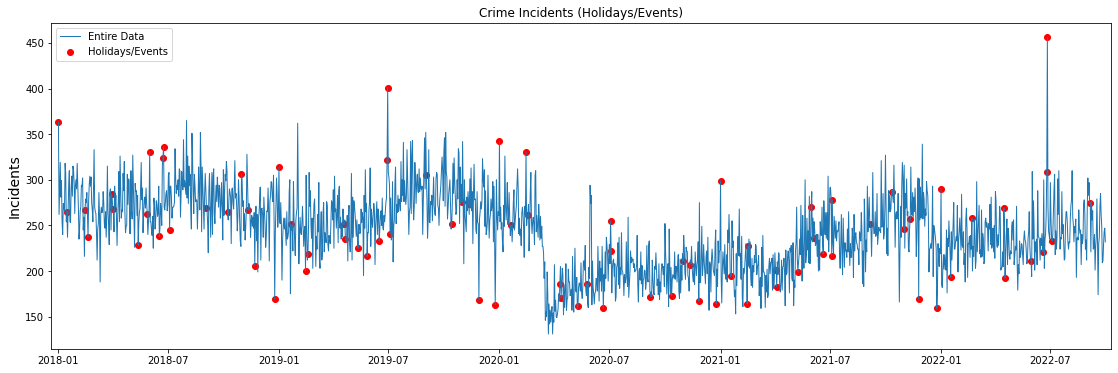

In [1984]:
result = pd.merge(pd.merge(cin_daily, covid_restrictions, on='Date', how='left'), events, on='Date', how='left')
result['Holiday'] = result['Holiday'].fillna("NotHoliday")
result['Holiday'] = result['Holiday'].astype("category")

result['DayOfWeek'] = result['Date'].dt.strftime('%A')
result['WeekNumber'] = result['Date'].dt.strftime("%U").astype(np.int32)
result.set_index('Date', inplace=True)


plotTS([[result['Incidents'], "Entire Data", "l"],
        [result[result['Holiday']!='NotHoliday']['Incidents'], "Holidays/Events", "m"]], 
       title_="Crime Incidents (Holidays/Events)")

From the plot we can see there is a correlation between holidays and number of incidents in San Francisco. Holidays/Events predictor will be used for future prediction.

In [1985]:
result = pd.get_dummies(result)

printVIF(result)
printVIF(result.drop(columns=['NEBusinessClose','BusinessMask']))

result = result.drop(columns=['NEBusinessClose','BusinessMask'])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                           feature        VIF
0                        Incidents   2.091792
1                      BarRestrict   2.541250
2                     BusinessMask  16.364856
3                     GathRestrict   2.874246
4                  NEBusinessClose  16.675993
5               OtherBusinessClose   1.443718
6                       PublicMask  15.654843
7               RestaurantRestrict  16.683613
8                       StayAtHome   4.373323
9                       WeekNumber   1.165670
10               Holiday_Christmas        inf
11             Holiday_ColumbusDay        inf
12            Holiday_EasterSunday        inf
13              Holiday_FathersDay        inf
14              Holiday_GoodFriday        inf
15               Holiday_Halloween        inf
16         Holiday_IndependenceDay        inf
17  Holiday_IndependenceDayHoliday        inf
18              Holiday_Juneteenth        inf
19                Holiday_LaborDay        inf
20               Holiday_MLKingDay

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Splitting data to train and test data set. Then ACF and PACF will be applied to time series to identify seasonality and correlation between lags.

In [1986]:
train_, test_ = trainTest(result)

result.head(5)

,Incidents,BarRestrict,GathRestrict,OtherBusinessClose,PublicMask,RestaurantRestrict,StayAtHome,WeekNumber,Holiday_Christmas,Holiday_ColumbusDay,...,Holiday_ThanksgivingDay,Holiday_ValentinesDay,Holiday_VeteransDay,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,363,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2018-01-02,262,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2018-01-03,290,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2018-01-04,319,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2018-01-05,281,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


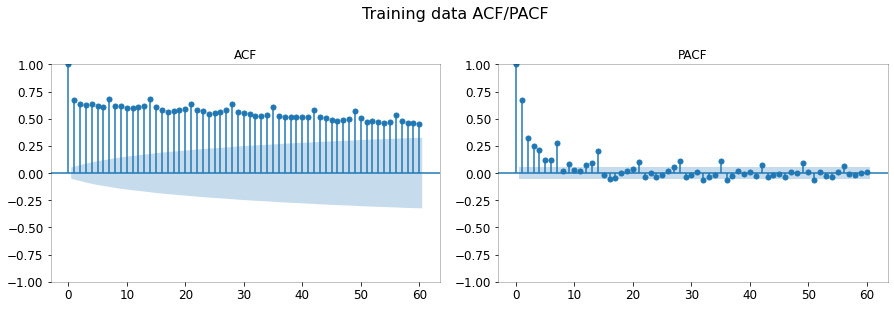

In [1987]:
acfPacf(train_['Incidents'], "Training data ACF/PACF")

From ACF and PACF we can see weekly seasonality. Already form the plot for ARIMA Autoregression of 5/6 can be identified.

In the next sections the results of Linear regression, SARIMAX, Poisson regressin and as an extra Neural Networks will be compared.

## Linear Regression

In [1988]:
x = train_.drop(columns=['Incidents'])
y = np.array(train_['Incidents'])

model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     57.30
Date:                Sat, 17 Dec 2022   Prob (F-statistic):          5.12e-230
Time:                        19:42:37   Log-Likelihood:                -6574.3
No. Observations:                1387   AIC:                         1.322e+04
Df Residuals:                    1353   BIC:                         1.339e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
BarRestrict 

The linear model performance in terms of adj. R2 of 0.57 is not bad.

In [1989]:
#influence = OLSInfluence(model)
predictions = model.predict(test_.drop(columns=[ 'Incidents']))
predictions.index =  test_.index

In [1990]:
print("Linear Regression without Lags:")
RMSE(test_['Incidents'], predictions)

Linear Regression without Lags:
RMSE:  34.07337475787895


34.07337475787895

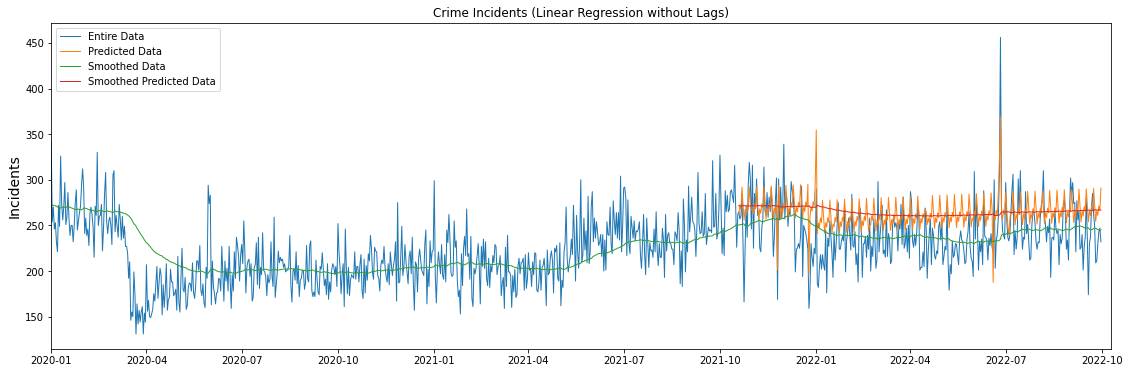

In [1991]:
plotTS([[result['Incidents'], "Entire Data", "l"],
        [predictions, "Predicted Data", "l"],
        [smooth_data, "Smoothed Data", "l"],
        [smoothData(predictions), "Smoothed Predicted Data", "l"]],
       title_="Crime Incidents (Linear Regression without Lags)",
       xlim_=[datetime.date(2020, 1, 1), datetime.date(2022, 10, 10)])

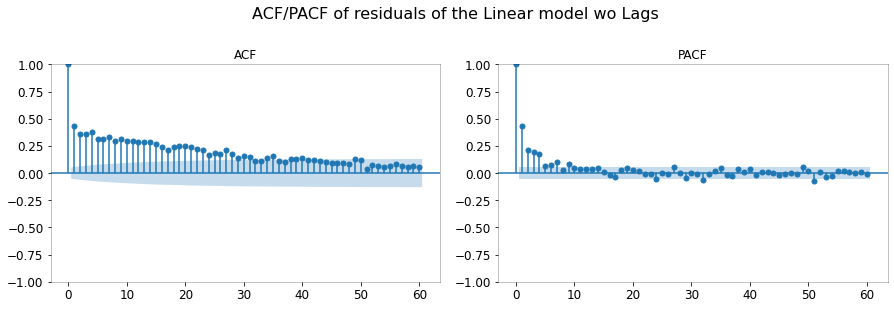

In [1992]:
acfPacf(model.resid, "ACF/PACF of residuals of the Linear model wo Lags")

But after looking at ACF/PACF we can see there is correlation in different lags. Next different lags of the response variable will be added to the dataset and the to the model to eliminate correlation of residuals. From smoothed line we can see some yearly trend. Than is why lag of 365 and lags from 1 to 62 will be added as predictors. After that using linear regression we will identify significant lags.

In [1993]:
result_ = result.copy()

result_['Incidents_365'] = result_['Incidents'].shift(365)
    
train_, test_ = trainTest(result_, lags_=range(1, 62))

In [1994]:
x = train_.drop(columns=['Incidents'])
y = np.array(train_['Incidents'])

model = sm.OLS(y, x).fit()
#model.summary()

ols_results = pd.DataFrame({'pvalues': model.pvalues})

ols_results[ols_results['pvalues']<0.05][13:]

,pvalues
DayOfWeek_Wednesday,1.022120e-03
Incidents_365,1.182259e-02
Incidents_1,1.191679e-10
Incidents_2,4.486907e-04
Incidents_3,1.534221e-02
Incidents_4,5.134934e-05
Incidents_7,3.091244e-02
Incidents_13,4.805094e-02
Incidents_40,3.813740e-02
Incidents_61,1.367039e-02


The p-values of lags 1,2,3,4,7,13,40,61,365 are less than 0.05 - significant. We will use these lags as new predictors.

In [1995]:
best_lags = [1,2,3,4,7,13,40,61,365]

result_ = result.copy()

train_, test_ = trainTest(result_, lags_=best_lags)

x = train_.drop(columns=['Incidents'])
y = np.array(train_['Incidents'])

model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     57.66
Date:                Sat, 17 Dec 2022   Prob (F-statistic):          8.65e-233
Time:                        19:42:37   Log-Likelihood:                -4641.5
No. Observations:                1022   AIC:                             9369.
Df Residuals:                     979   BIC:                             9581.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
BarRestrict 

The adj. R2 has increased to 0.7. and from ACF/PACF of residuals we can see no correlation of lags anymore.

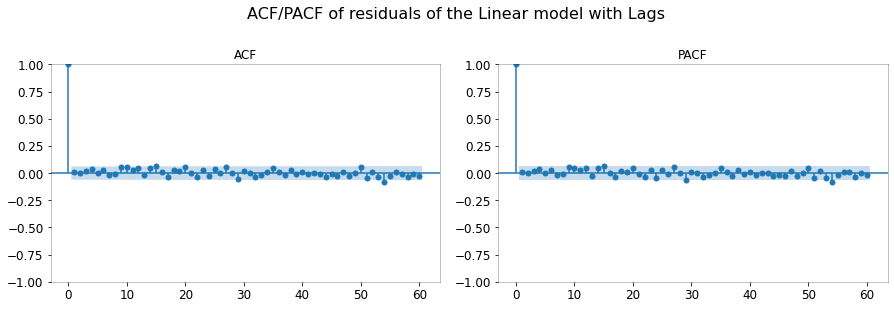

In [1996]:
acfPacf(model.resid, "ACF/PACF of residuals of the Linear model with Lags")

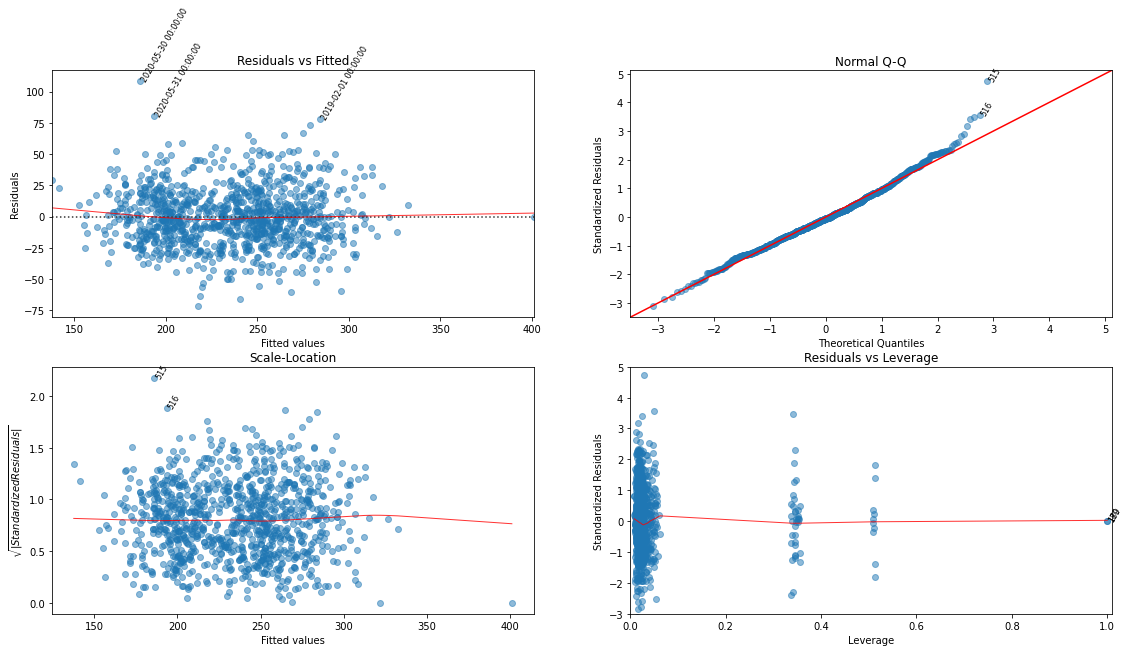

In [1997]:
with warnings.catch_warnings(record=True):
    diagnostic_plots(x, train_['Incidents'], model_fit=model)

Also from residuals plot we can see no non linear relationship or signs of non-constant vairance. Except two outliers residuals are normally distributed. On 2020-05-30 and 2020-05-31 some event has impacted the number of incidents that is not included in this model.

In [1998]:
train_.iloc[515:517].index

DatetimeIndex(['2020-05-30', '2020-05-31'], dtype='datetime64[ns]', name='Date', freq=None)

In [1999]:
pred_ols = stepPredict(model, test_, best_lags)

print("Linear Regression with Lags(Step prediction):")
RMSE_ols = RMSE(test_['Incidents'], pred_ols)

Linear Regression with Lags(Step prediction):
RMSE:  27.160635469282113


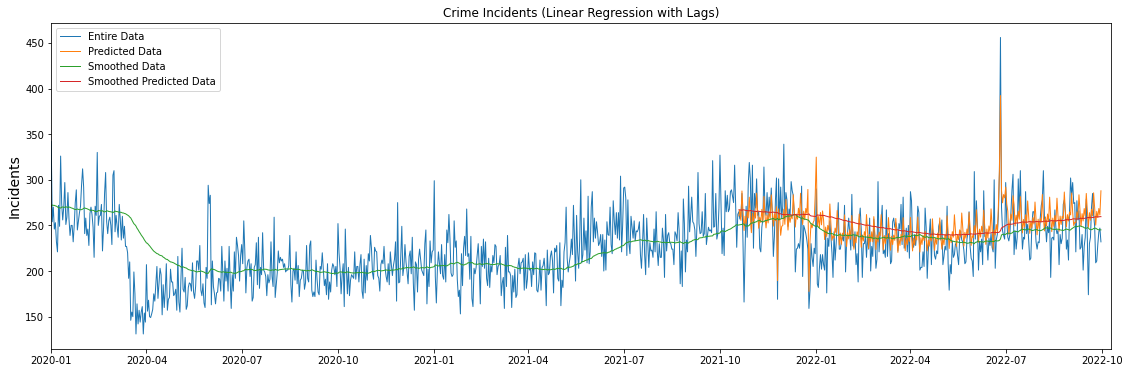

In [2000]:
plotTS([[result['Incidents'], "Entire Data", "l"],
        [pred_ols, "Predicted Data", "l"],
        [smooth_data, "Smoothed Data", "l"],
        [smoothData(pred_ols), "Smoothed Predicted Data", "l"]],
       title_="Crime Incidents (Linear Regression with Lags)",
       xlim_=[datetime.date(2020, 1, 1), datetime.date(2022, 10, 10)])

## SARIMAX

Since we already know that there is seasonal component included in the time series also there is a correlation between holidays/events, restrictions, and some lags, next we will use Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors (SARIMAX).

Since ARIMA/auto_arima function does not allow multiple seasonalities we will include all lags after lag 7 (13,40,61,365) in addition to holidays/events, restrictions, as eXogenous factors, and find best AR, MA and seasnal AR, MA part with auto_arima function.

In [2001]:
sarimax_lag = [13,40,61,365]

result_ = result.copy()

train_, test_ = trainTest(result_, lags_=sarimax_lag)

In [2002]:
model_ = auto_arima(train_['Incidents'], start_p=0, start_q=0, trace=True, seasonal=True, m=7, 
                    X=train_.drop(columns=['Incidents']), n_fits=10)
model_.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=9533.555, Time=6.37 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=9585.840, Time=0.57 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=9466.187, Time=6.13 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=9492.205, Time=6.33 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=9583.840, Time=1.75 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=9483.022, Time=1.98 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=9457.850, Time=12.67 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=9460.382, Time=12.22 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=9459.500, Time=6.68 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=9531.246, Time=10.67 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=9435.720, Time=12.76 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=9442.962, Time=7.19 sec
 ARIMA(2,0,0)(2,0,1)[7] intercept   : AIC=9435.715, Time=13.23 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=9438.308, Time=7.47 sec
 ARIMA(2,0,0)(2,0,2)[7] inte

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1022
Model:               SARIMAX(5, 0, 1)   Log Likelihood               -4640.884
Date:                Sat, 17 Dec 2022   AIC                           9377.769
Time:                        19:48:59   BIC                           9614.386
Sample:                    01-01-2019   HQIC                          9467.605
                         - 10-18-2021                                         
Covariance Type:                  opg                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
intercept                          1.5841      1.205      1.314      0.189      -0.778       3.947
BarRestrict                      -25.1955      5.701     -4.420      0.000     -36.369     -14.022
GathRestrict                     -13.3693      6.251     -2.139      0.032     -25.621      -1.118
OtherBusinessClose               -19.8263      6.303     -3.145      0.002     -32.181      -7.472
PublicMask                       -10.7440      7.529     -1.427      0.154     -25.501       4.013
RestaurantRestrict                 6.4549      8.027      0.804      0.421      -9.277      22.187
StayAtHome                       -11.4921      9.929     -1.157      0.247     -30.953       7.969
WeekNumber                         0.2796      0.206      1.357      0.175      -0.124       0.684
Holiday_Christmas                -48.4118     20.190     -2.398      0.016     -87.984      -8.840
Holiday_ColumbusDay               16.7599     15.387      1.089      0.276     -13.399      46.919
Holiday_EasterSunday              28.1099     30.602      0.919      0.358     -31.870      88.090
Holiday_FathersDay                 6.2011     24.980      0.248      0.804     -42.758      55.160
Holiday_GoodFriday                11.3106     40.998      0.276      0.783     -69.045      91.666
Holiday_Halloween                 16.3534     30.032      0.545      0.586     -42.507      75.214
Holiday_IndependenceDay           16.6043     18.225      0.911      0.362     -19.115      52.324
Holiday_IndependenceDayHoliday    49.7719     51.929      0.958      0.338     -52.008     151.551
Holiday_Juneteenth             -1.171e-15      0.001  -1.78e-12      1.000      -0.001       0.001
Holiday_LaborDay                  27.8898     15.253      1.829      0.067      -2.005      57.784
Holiday_MLKingDay                 20.4155     16.371      1.247      0.212     -11.670      52.501
Holiday_MemorialDay               23.8814     11.146      2.143      0.032       2.036      45.726
Holiday_MothersDay                25.0376     42.587      0.588      0.557     -58.431     108.506
Holiday_NationalDonutDay          24.3551     21.818      1.116      0.264     -18.408      67.118
Holiday_NewYearsDay              101.5732     30.401      3.341      0.001      41.988     161.159
Holiday_NotHoliday                27.2857      7.282      3.747      0.000      13.012      41.559
Holiday_PresidentsDay             22.3904     15.296      1.464      0.143      -7.590      52.371
Holiday_SanFranciscoPride1        91.8418    179.431      0.512      0.609    -259.836     443.519
Holiday_SanFranciscoPride2       190.5200    119.003      1.601      0.109     -42.723     423.763
Holiday_ThanksgivingDay          -47.6068     13.578     -3.506      0.000     -74.220     -20.994
Holiday_ValentinesDay              6.5482      9.647      0.679      0.497     -12.360      25.456
Holiday_VeteransDay               16.1327     33.033      0.488      0.62

As we can see the best SARIMAX model is SARIMAX(5,0,1)(0,0,0)[7]. Applying this paramether let's fit the model.

In [2003]:
p,d,q = (5,0,1)
P,D,Q,S = (0,0,0,7)

model_arima = ARIMA(train_['Incidents'], order=(p,d,q), seasonal_order=(P,D,Q,S), 
              exog=train_.drop(columns=['Incidents']))

model_arima_fit = model_arima.fit()
model_arima_fit.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Incidents   No. Observations:                 1022
Model:                 ARIMA(5, 0, 1)   Log Likelihood               -4642.734
Date:                Sat, 17 Dec 2022   AIC                           9381.467
Time:                        19:49:05   BIC                           9618.084
Sample:                    01-01-2019   HQIC                          9471.303
                         - 10-18-2021                                         
Covariance Type:                  opg                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            101.0273     14.276      7.077      0.000      73.046     129.008
BarRestrict                      -24.9109      5.618     -4.434      0.000     -35.922     -13.900
GathRestrict                     -13.2413      6.431     -2.059      0.039     -25.846      -0.637
OtherBusinessClose               -19.5516      6.269     -3.119      0.002     -31.839      -7.265
PublicMask                       -10.7897      7.842     -1.376      0.169     -26.160       4.581
RestaurantRestrict                 6.3777      7.952      0.802      0.423      -9.208      21.963
StayAtHome                       -11.3257      9.470     -1.196      0.232     -29.887       7.236
WeekNumber                         0.3853      0.208      1.855      0.064      -0.022       0.793
Holiday_Christmas                -73.5002     19.449     -3.779      0.000    -111.619     -35.382
Holiday_ColumbusDay               -8.3551     15.610     -0.535      0.592     -38.949      22.239
Holiday_EasterSunday               3.0497     24.759      0.123      0.902     -45.477      51.576
Holiday_FathersDay               -18.8231     23.175     -0.812      0.417     -64.246      26.599
Holiday_GoodFriday               -13.7883     33.596     -0.410      0.682     -79.636      52.059
Holiday_Halloween                 -8.7075     29.873     -0.291      0.771     -67.258      49.843
Holiday_IndependenceDay           -8.4759     17.446     -0.486      0.627     -42.670      25.718
Holiday_IndependenceDayHoliday    24.7468     35.947      0.688      0.491     -45.708      95.202
Holiday_Juneteenth              -4.81e-15      0.002  -3.13e-12      1.000      -0.003       0.003
Holiday_LaborDay                   2.7517     14.860      0.185      0.853     -26.373      31.876
Holiday_MLKingDay                 -4.6698     16.005     -0.292      0.770     -36.040      26.700
Holiday_MemorialDay               -1.2513     10.780     -0.116      0.908     -22.380      19.878
Holiday_MothersDay                -0.0144     30.128     -0.000      1.000     -59.064      59.036
Holiday_NationalDonutDay          -0.7685     26.267     -0.029      0.977     -52.251      50.714
Holiday_NewYearsDay               76.4622     26.639      2.870      0.004      24.251     128.673
Holiday_NotHoliday                 2.8989      6.494      0.446      0.655      -9.829      15.627
Holiday_PresidentsDay             -2.7096     14.298     -0.190      0.850     -30.734      25.315
Holiday_SanFranciscoPride1        66.7484    206.054      0.324      0.746    -337.110     470.607
Holiday_SanFranciscoPride2       165.4320    146.231      1.131      0.258    -121.176     452.040
Holiday_ThanksgivingDay          -72.6535     12.784     -5.683      0.000     -97.711     -47.597
Holiday_ValentinesDay            -18.4612      8.833     -2.090      0.037     -35.774      -1.149
Holiday_VeteransDay               -8.8839     30.918     -0.287      0.77

In [2004]:
pred_arima = stepPredict(model_arima_fit, test_, lags=sarimax_lag, type_="sarimax")

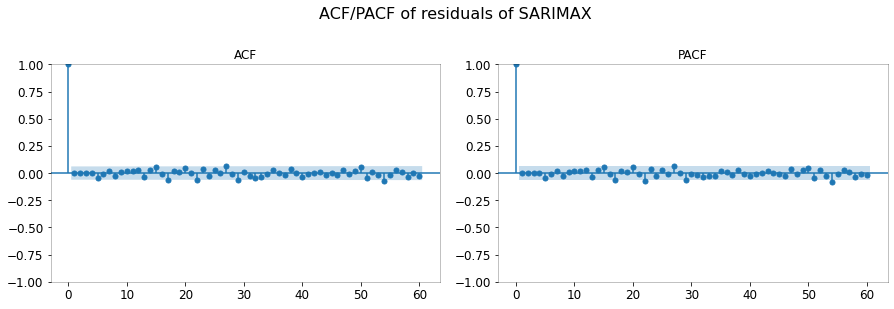

In [2005]:
acfPacf(model_arima_fit.resid, "ACF/PACF of residuals of SARIMAX")

In [2006]:
print("SARIMAX:")
RMSE_sarimax = RMSE(test_['Incidents'], pred_arima)

SARIMAX:
RMSE:  25.311035185066014


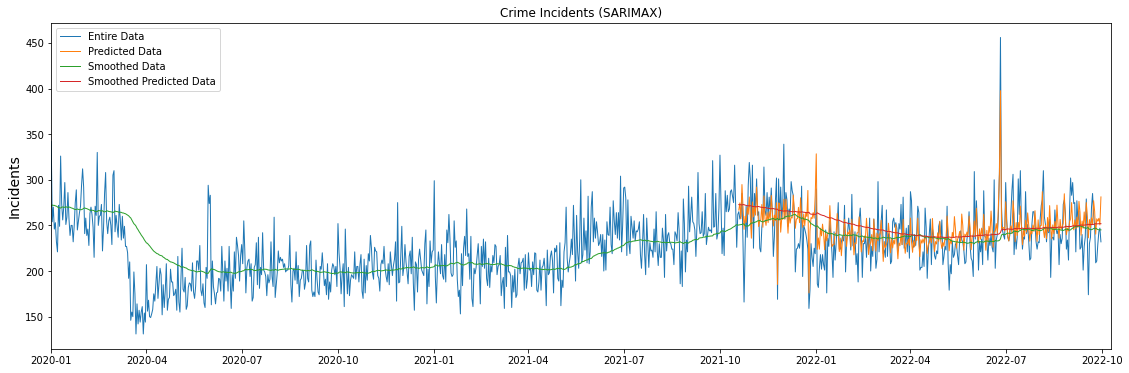

In [2007]:
plotTS([[result['Incidents'], "Entire Data", "l"],
        [pred_arima, "Predicted Data", "l"],
        [smooth_data, "Smoothed Data", "l"],
        [smoothData(pred_arima), "Smoothed Predicted Data", "l"]],
       title_="Crime Incidents (SARIMAX)",
       xlim_=[datetime.date(2020, 1, 1), datetime.date(2022, 10, 10)])

As in the linear model lokking at ACF/PACF of residuals we can see that there is no correlation at any lag in SARIMAX model. The performance of SARIMAX is better than of the linear model (lower test RMSE). 

## Poisson Regression

For poisson regression mean and variance of the time series have to be equal. As shown below the mean and variance are not equal. Unfortunately lambda transformation to equalize mean and variance does not improve the model. 

In [2008]:
print("Mean:\t\t", round(np.mean(result['Incidents']), 2))
print("Variance:\t", round(np.var(result['Incidents']), 2))


min_ = abs(np.mean(result['Incidents']) - np.var(result['Incidents']))
best_lambda = 1
for l in [x / 1000 for x in range(500, 999)]:
    tmp = abs(np.mean(result['Incidents']**l) - np.var(result['Incidents']**l))
    if tmp < min_:
        min_ = tmp
        best_lambda = l

print("\nBest Lambda:\t", best_lambda)
print("Mean:\t\t", round(np.mean(result['Incidents']**best_lambda), 2))
print("Variance:\t", round(np.var(result['Incidents']**best_lambda), 2))

result_ = result.copy()
result_ = result_.drop(columns=['Holiday_Juneteenth'])

train_, test_ = trainTest(result_, lags_=best_lags, lambda_=best_lambda)
expr = 'Incidents ~ BarRestrict + GathRestrict + OtherBusinessClose + PublicMask + RestaurantRestrict + StayAtHome + WeekNumber + Holiday_Christmas + Holiday_ColumbusDay + Holiday_EasterSunday + Holiday_FathersDay + Holiday_GoodFriday + Holiday_Halloween + Holiday_IndependenceDay + Holiday_IndependenceDayHoliday + Holiday_LaborDay + Holiday_MLKingDay + Holiday_MemorialDay + Holiday_MothersDay + Holiday_NationalDonutDay + Holiday_NewYearsDay + Holiday_NotHoliday + Holiday_PresidentsDay + Holiday_SanFranciscoPride1 + Holiday_SanFranciscoPride2 + Holiday_ThanksgivingDay + Holiday_ValentinesDay + Holiday_VeteransDay + DayOfWeek_Friday + DayOfWeek_Monday + DayOfWeek_Saturday + DayOfWeek_Sunday + DayOfWeek_Thursday + DayOfWeek_Tuesday + DayOfWeek_Wednesday + Incidents_1 + Incidents_2 + Incidents_3 + Incidents_4 + Incidents_7 + Incidents_13 + Incidents_40 + Incidents_61 + Incidents_365'

y_train, X_train = dmatrices(expr, train_, return_type='dataframe')

model_poisson = dm.Poisson(endog=y_train, exog=X_train)
model_fit_poisson = model_poisson.fit(maxiter=100)

print("\nMean Poisson Deviance: ",mean_poisson_deviance(y_train, model_fit_poisson.predict(X_train)),"\n" )
print(model_fit_poisson.summary())

Mean:		 244.58
Variance:	 1676.47

Best Lambda:	 0.752
Mean:		 62.36
Variance:	 62.39
Optimization terminated successfully.
         Current function value: 3.126673
         Iterations 27

Mean Poisson Deviance:  0.32098036608466024 

                          Poisson Regression Results                          
Dep. Variable:              Incidents   No. Observations:                 1022
Model:                        Poisson   Df Residuals:                      979
Method:                           MLE   Df Model:                           42
Date:                Sat, 17 Dec 2022   Pseudo R-squ.:                  0.1133
Time:                        19:49:07   Log-Likelihood:                -3195.5
converged:                       True   LL-Null:                       -3603.9
Covariance Type:            nonrobust   LLR p-value:                3.120e-144
                                     coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

We will stay with not lambda-transformed dataset.

In [2009]:
result_ = result.copy()
result_ = result_.drop(columns=['Holiday_Juneteenth'])

train_, test_ = trainTest(result_, lags_=best_lags)

In [2010]:
#print("Incidents ~ " + " + ".join(str(x) for x in model.params.index))
expr = 'Incidents ~ BarRestrict + GathRestrict + OtherBusinessClose + PublicMask + RestaurantRestrict + StayAtHome + WeekNumber + Holiday_Christmas + Holiday_ColumbusDay + Holiday_EasterSunday + Holiday_FathersDay + Holiday_GoodFriday + Holiday_Halloween + Holiday_IndependenceDay + Holiday_IndependenceDayHoliday + Holiday_LaborDay + Holiday_MLKingDay + Holiday_MemorialDay + Holiday_MothersDay + Holiday_NationalDonutDay + Holiday_NewYearsDay + Holiday_NotHoliday + Holiday_PresidentsDay + Holiday_SanFranciscoPride1 + Holiday_SanFranciscoPride2 + Holiday_ThanksgivingDay + Holiday_ValentinesDay + Holiday_VeteransDay + DayOfWeek_Friday + DayOfWeek_Monday + DayOfWeek_Saturday + DayOfWeek_Sunday + DayOfWeek_Thursday + DayOfWeek_Tuesday + DayOfWeek_Wednesday + Incidents_1 + Incidents_2 + Incidents_3 + Incidents_4 + Incidents_7 + Incidents_13 + Incidents_40 + Incidents_61 + Incidents_365'

y_train, X_train = dmatrices(expr, train_, return_type='dataframe')

model_poisson = dm.Poisson(endog=y_train, exog=X_train)
model_fit_poisson = model_poisson.fit(maxiter=100)

print("\nMean Poisson Deviance: ",mean_poisson_deviance(y_train, model_fit_poisson.predict(X_train)),"\n" )
print(model_fit_poisson.summary())

         Current function value: 4.736739
         Iterations: 100

Mean Poisson Deviance:  2.1938070067350104 

                          Poisson Regression Results                          
Dep. Variable:              Incidents   No. Observations:                 1022
Model:                        Poisson   Df Residuals:                      979
Method:                           MLE   Df Model:                           42
Date:                Sat, 17 Dec 2022   Pseudo R-squ.:                  0.3648
Time:                        19:49:07   Log-Likelihood:                -4840.9
converged:                      False   LL-Null:                       -7621.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          4.7484        nan     

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


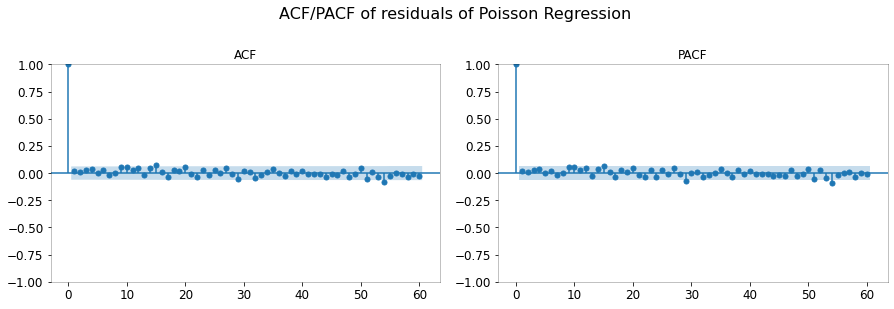

In [2011]:
acfPacf(model_fit_poisson.resid, "ACF/PACF of residuals of Poisson Regression")

In [2012]:
pred_poisson = stepPredict(model_fit_poisson, test_, best_lags, type_="poisson")

print("Poisson Regression:")
RMSE_poisson = RMSE(pred_poisson, test_['Incidents'])

Poisson Regression:
RMSE:  25.955275441126016


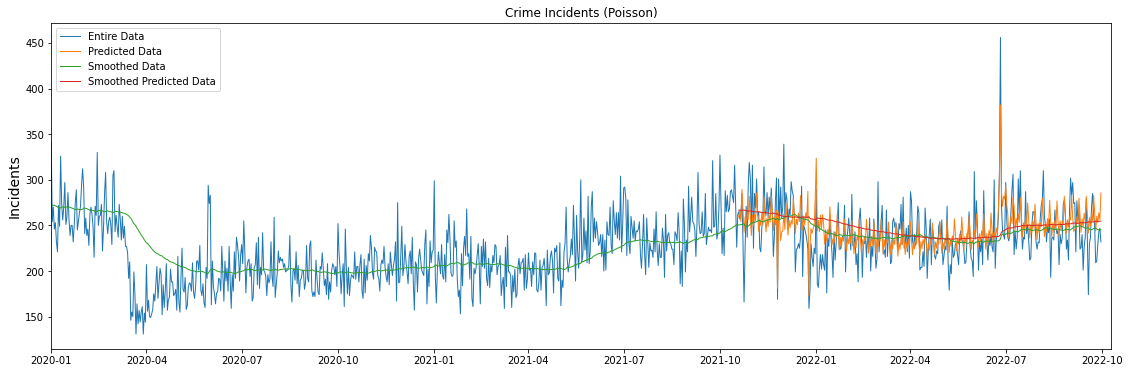

In [2013]:
plotTS([[result['Incidents'], "Entire Data", "l"],
        [pred_poisson, "Predicted Data", "l"],
        [smooth_data, "Smoothed Data", "l"],
        [smoothData(pred_poisson), "Smoothed Predicted Data", "l"]],
       title_="Crime Incidents (Poisson)",
       xlim_=[datetime.date(2020, 1, 1), datetime.date(2022, 10, 10)])

The performance of poisson regression is similar to SARIMAX, with slightly worse test RMSE.

## Neural Networks (Extra)

In [2014]:
result_ = result.copy()

#inc_min = min(result_['Incidents'])
#inc_max = max(result_['Incidents'])
#result_['Incidents'] = (result_['Incidents']-inc_min)/(inc_max-inc_min)

train_, test_ = trainTest(result_, lags_=best_lags)

p = train_.shape[1]-1
X_train, y_train = train_.iloc[:,1:p+1], train_.iloc[:,0]
X_test, y_test = test_.iloc[:,1:p+1], test_.iloc[:,0]

In [2015]:
model_nn = models.Sequential()
model_nn.add(layers.Dense(16, activation='relu', input_shape=(p,)))
model_nn.add(layers.Dense(2, activation='relu'))
model_nn.add(layers.Dense(1, activation='linear')) 

model_nn.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_136 (Dense)           (None, 16)                736       
                                                                 
 dense_137 (Dense)           (None, 2)                 34        
                                                                 
 dense_138 (Dense)           (None, 1)                 3         
                                                                 
Total params: 773
Trainable params: 773
Non-trainable params: 0
_________________________________________________________________


In [2016]:
nepochs = 30000
model_nn.compile(optimizer='adam',
              loss='mse')
history = model_nn.fit(X_train, y_train,
          epochs=nepochs,
          batch_size=60000,
          shuffle=False,
          validation_data=(X_test, y_test), verbose=0, callbacks=[TqdmCallback(verbose=0)])

history_dict = history.history

  0%|                                                                                                 | 0/30000 [00:00<?, ?epoch/s]2022-12-17 19:49:12.802015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-17 19:49:12.947693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
100%|█████████████████████████████████████████████████████████████| 30000/30000 [07:35<00:00, 65.90epoch/s, loss=493, val_loss=640]


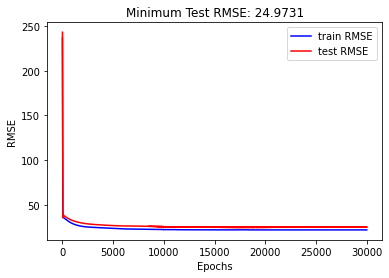

In [2017]:
plt.clf()
train_rmse = np.sqrt(history_dict['loss'])
test_rmse = np.sqrt(history_dict['val_loss'])

plt.plot(range(1,nepochs+1), train_rmse, label='train RMSE',color="blue")
plt.plot(range(1,nepochs+1), test_rmse, label='test RMSE',color="red")

plt.title('Minimum Test RMSE: ' + str(round(min(test_rmse),4)))
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.show()

2022-12-17 19:56:48.059043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


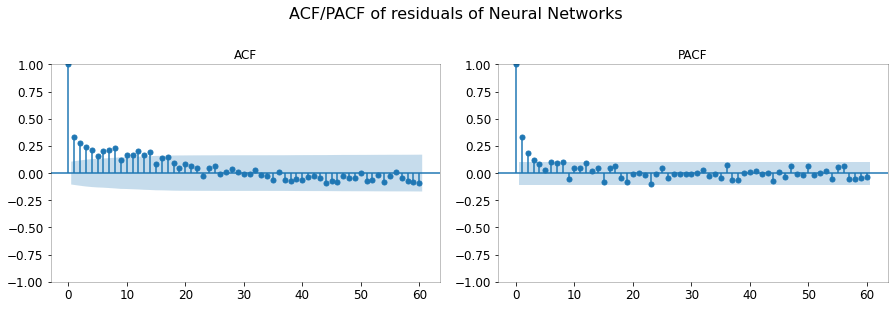

In [2018]:
pred_nn = stepPredict(model_nn, test_, best_lags, type_="NN")

acfPacf( (pred_nn-test_['Incidents']), "ACF/PACF of residuals of Neural Networks")

In [2019]:
print("Neural Networks:")
RMSE_nn = RMSE(pred_nn, test_['Incidents'])

Neural Networks:
RMSE:  27.777894101373214


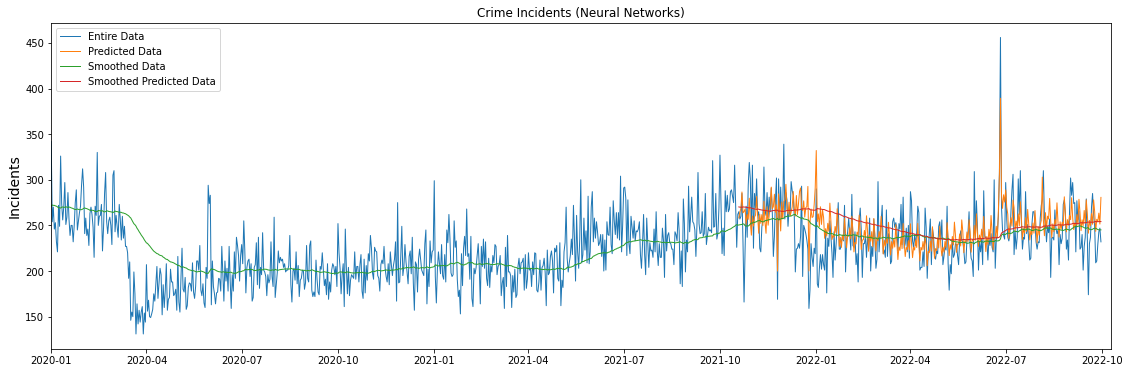

In [2020]:
plotTS([[result['Incidents'], "Entire Data", "l"],
        [pred_nn, "Predicted Data", "l"],
        [smooth_data, "Smoothed Data", "l"],
        [smoothData(pred_nn), "Smoothed Predicted Data", "l"]],
       title_="Crime Incidents (Neural Networks)",
       xlim_=[datetime.date(2020, 1, 1), datetime.date(2022, 10, 10)])

The performance of NN is worst. With significant correlations at different lags at ACF/PACF and with highest test RMSE.

## Comparition of test RMSE of the models

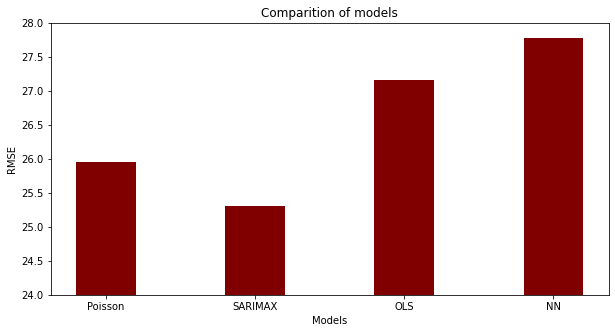

In [2021]:
data = {'Poisson':RMSE_poisson,
        'SARIMAX':RMSE_sarimax, 
        'OLS':RMSE_ols, 
        'NN':RMSE_nn}
models = list(data.keys())
rmses = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(models, rmses, color ='maroon', width = 0.4)
 
plt.xlabel("Models")
plt.ylabel("RMSE")
plt.ylim(24, 28)
plt.title("Comparition of models")
plt.show()

Overall SARIMAX performs best with lowest test RMSE, followed by Poisson regression.

## Prediction

Using same paramethers and exogenous factors for SARIMAX we will predict crime incidents for one year using entire dataset as train data.

In [2022]:
#Generating exogenous predictors and setting train data
result_, exog_ = generateTest(result, covid_restrictions,events, sarimax_lag)

exog_['Incidents'] = -1

p,d,q = (5,0,1)
P,D,Q,S = (0,0,0,7)

model_arima = ARIMA(result_['Incidents'], order=(p,d,q), seasonal_order=(P,D,Q,S), 
              exog=result_.drop(columns=['Incidents']))

model_arima_fit = model_arima.fit()
pred_arima = stepPredict(model_arima_fit, exog_, sarimax_lag, type_="sarimax")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Linear model with same train data and exogenous dataset as previously done with SARIMAX.

In [2023]:
result_, exog_ = generateTest(result, covid_restrictions,events, best_lags)

exog_['Incidents'] = -1

x = result_.drop(columns=['Incidents'])
y = np.array(result_['Incidents'])

model_ols = sm.OLS(y, x).fit()
pred_ols = stepPredict(model_ols, exog_, best_lags)

Prediction with poisson regression.

In [2024]:
result_p = result.copy()
#result_p['Incidents'] = result_p['Incidents']**best_lambda

for i in best_lags:
    result_p['Incidents_'+str(i)] = result_p['Incidents'].shift(i)

result_p = result_p.dropna(inplace=False)

expr = "Incidents ~ "+" + ".join(str(x) for x in exog_.drop(columns=['Incidents']).columns)

y_train, X_train = dmatrices(expr, result_p, return_type='dataframe')

model_poisson = dm.Poisson(endog=y_train, exog=X_train)
model_fit_poisson = model_poisson.fit(maxiter=100)

pred_poisson = stepPredict(model_fit_poisson, exog_, best_lags, type_="poisson") #**(1/best_lambda)

#pred_poisson

         Current function value: 4.746673
         Iterations: 100


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction without training to entier dataset, but using previously created NN model.

In [2025]:
pred_nn = stepPredict(model_nn, exog_, best_lags, type_="NN")


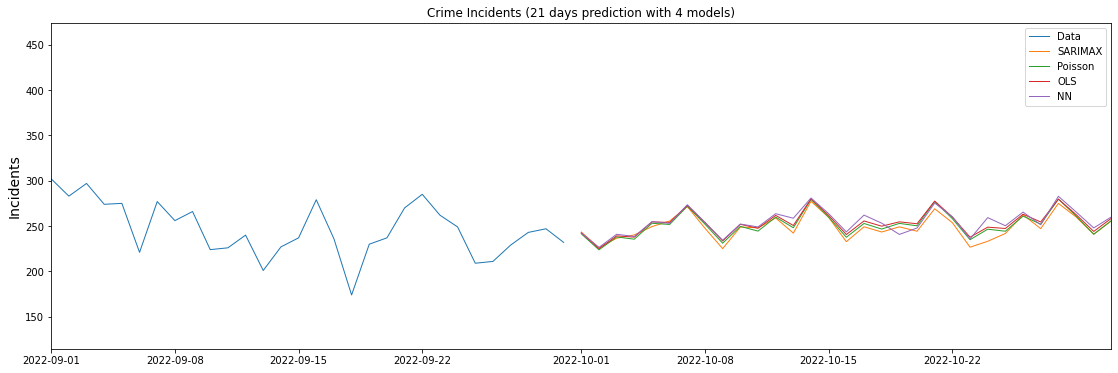

In [2026]:
plotTS([[result['Incidents'], "Data", "l"],
        [pred_arima, "SARIMAX", "l"],
        [pred_poisson, "Poisson", "l"],
        [pred_ols, "OLS", "l"],
        [pred_nn, "NN", "l"]],
       title_="Crime Incidents (21 days prediction with 4 models)",
       xlim_=[datetime.date(2022, 9, 1), datetime.date(2022, 10, 31)])

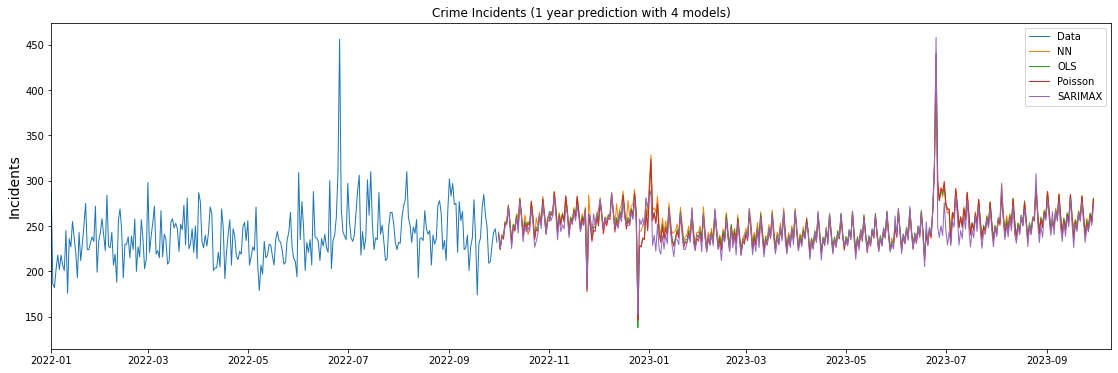

In [2027]:
plotTS([[result['Incidents'], "Data", "l"],
        [pred_nn, "NN", "l"],
        [pred_ols, "OLS", "l"],
        [pred_poisson, "Poisson", "l"],
        [pred_arima, "SARIMAX", "l"]],
       title_="Crime Incidents (1 year prediction with 4 models)",
       xlim_=[datetime.date(2022, 1, 1), datetime.date(2023, 10, 10)])

## Conclusion

All four models perform similarly after identifying the most significant predictors. In terms of test RMSE SARIMAX performs best and have chosen as final model SARIMAX(5,0,1,0,0,0,0, exog). But the most important predictors are egogenous predictors that we could identify previously. The majority of hikes and drops of incidents are because of holidays and big event in San Francisco. Also usually starting from monday until friday number of incidents increases and weekends drops. At the Christmas number of incidents drop significantly and rise at new year's eve. When looking at the plot we can see that at the beginning of the year until end of June number of incidents are relatively less than before and after. 

In the project we predict incidents of all categories in entire San Francisco. But similarly the data for specific category and location or district can be filtered out and applying same technic can be predicted.